# Theory

Some of the rates related formulas are from Leif Andersen's 3-volume book. 

In [1]:
import IPython; IPython.display.HTML('''<script>code_show=false; function code_toggle() { if (code_show){ $('div.nbinput').show(); } else { $('div.nbinput').hide(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Automatic Differentiation Example

* 把數學函數全部重新定義一遍，output type 不用 float 而是用一個新的 class（Variable）同時存下數值（data）和導數（grad）
    * 等於把本來的 $\mathbb R \mapsto \mathbb R$ 函數都變成 $\mathbb R \mapsto \mathbb R^2$，同時輸出點值和導數
* Variable class 超載所有 arithmetic operator 把微分規則寫在裡面（如萊布尼茲公式）
* 在自定義的數學函數裡手動給他們的導數，例如
\begin{align*}
\frac{d}{dx}\sin(x) = \cos(x),\qquad\frac{d}{dx}\cos(x) = -\sin(x).
\end{align*}
* Nothing is symbolic

In [5]:
import math

class Variable:
    
    def __init__(self, data, grad):
        self.data = data
        self.grad = grad
        
    def __add__(self, other):
        res_data = self.data + other.data
        res_grad = self.grad + other.grad
        
        return Variable(res_data, res_grad)

    def __mul__(self, other):
        res_data = self.data * other.data
        res_grad = self.data * other.grad + self.grad * other.data      # Leibniz rule

        return Variable(res_data, res_grad)

    def __repr__(self):
        return f'data: {self.data}, grad: {self.grad}'

def sin(x):
    return Variable(math.sin(x), math.cos(x))

def cos(x):
    return Variable(math.cos(x), -math.sin(x))

def f(x):
    return sin(x)*cos(x) + cos(x)*sin(x)  # equals sin(2x) with derivative  2 cos(2x)

f(3.1415926)   # expecting point value: sin(2*pi) = 0 and derivative 2*cos(2*pi) = 2

data: -1.0717958634011433e-07, grad: 1.9999999999999885

## Crank-Nicolson Summary

To solve $u_t = u_{xx}$, first discretize $x$ to get the system of ODEs 
\begin{align*}
\dot U = \delta_x^+\delta_x^- U, 
\end{align*}
where the operators are defined as
\begin{align*}
\delta_x^+ &= \frac{S-I}{\Delta x},\\
\delta_x^- &= \frac{I-S^{-1}}{\Delta x},\\
\delta_x^+\delta_x^- &= \frac{S-2I+S^{-1}}{(\Delta x)^2}, 
\end{align*}
and $U$ is a vector function of $t$:  
\begin{align*}
U(t) = \begin{pmatrix}
U_1(t)\\
U_2(t)\\
U_3(t)\\
\vdots\\
U_{m-1}(t)\\
\end{pmatrix}. 
\end{align*}
In matrix form, the operators are 
\begin{align*}
SU &= \begin{pmatrix}
U_2\\
U_3\\
U_4\\
\vdots\\
U_{m}\\
\end{pmatrix} = \begin{pmatrix}
0 & 1 &&&\\
& 0 & 1 &&\\
&& 0 & 1 &\\
&&& \ddots \\
&&&& 0\\
\end{pmatrix}U + \begin{pmatrix}
0\\
0\\
0\\
\vdots\\
\beta_R\\
\end{pmatrix}, \\
S^{-1}U &= \begin{pmatrix}
U_0\\
U_1\\
U_2\\
\vdots\\
U_{m-2}\\
\end{pmatrix} = \begin{pmatrix}
0 &&&&\\
1 & 0 &&&\\
& 1 & 0 &&\\
&&& \ddots \\
&&& 1 & 0\\
\end{pmatrix}U + \begin{pmatrix}
\beta_L\\
0\\
0\\
\vdots\\
0\\
\end{pmatrix}, 
\end{align*}
where $\beta_L = U_0$ and $\beta_R = U_m$ are Dirichlet boundary conditions. 
Now discretize $t$ and apply the trapezoidal rule
\begin{align*}
U^{n+1} &= U^{n} + \int_{t_n}^{t_{n+1}} \dot U\,dt\\
&= U^{n} + \int_{t_n}^{t_{n+1}} \delta_x^+\delta_x^- U\,dt\\
&\approx U^{n} + \Delta t\delta_x^+\delta_x^- \left(\frac{U^{n}+U^{n+1}}{2}\right). 
\end{align*}
So the Crank-Nicolson method is 
\begin{align*}
\left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)U^{n+1} = \left(I + \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)U^{n}. 
\end{align*}
To write in matrix form, expand the operator to get
\begin{align*}
\left(I - \alpha\left(S-2I+S^{-1}\right) \right)U^{n+1} = \left(I + \alpha\left(S-2I+S^{-1}\right) \right)U^{n}, 
\end{align*}
where
\begin{align*}
\alpha = \frac{\Delta t}{2(\Delta x)^2}. 
\end{align*}
Rearrange to get
\begin{align*}
\left(-\alpha S + (1+2\alpha)I -\alpha S^{-1} \right)U^{n+1} = \left(\alpha S + (1-2\alpha)I + \alpha S^{-1} \right)U^{n}. 
\end{align*}
Thus the scheme in matrix form is
\begin{align*}
&
\begin{pmatrix}
1+2\alpha & -\alpha&&&&\\
-\alpha & 1+2\alpha & -\alpha&&&\\
& -\alpha & 1+2\alpha & -\alpha&&\\
&&& \ddots &\\
&&& -\alpha & 1+2\alpha & -\alpha \\
&&&& -\alpha & 1+2\alpha
\end{pmatrix}U^{n+1} + \begin{pmatrix}
-\alpha\beta_L^{n+1}\\
0\\
0\\
\vdots\\
0\\
-\alpha\beta_R^{n+1}\\
\end{pmatrix} \\
&= 
\begin{pmatrix}
1-2\alpha & \alpha&&&&\\
\alpha & 1-2\alpha & \alpha&&&\\
& \alpha & 1-2\alpha & \alpha&&\\
&&& \ddots &\\
&&& \alpha & 1-2\alpha & \alpha \\
&&&& \alpha & 1-2\alpha
\end{pmatrix}U^{n} + \begin{pmatrix}
\alpha\beta_L^{n}\\
0\\
0\\
\vdots\\
0\\
\alpha\beta_R^{n}\\
\end{pmatrix}. 
\end{align*}
Note that the solver can only go forward in time: One can only solve the unknown $U^{n+1}$ given $U^{n}$, not the other way around, or otherwise the scheme will become unconditionally unstable. 

### Neumann Boundary Conditions
When Neumann boundary conditions $\beta_L^\prime, \beta_R^\prime$ are given instead of Dirichlet, we set
\begin{align*}
&-\frac{3}{2\Delta x} U_0 + \frac{4}{2\Delta x} U_1 -\frac{1}{2\Delta x} U_2 = \beta_L^\prime, \\
&\frac{3}{2\Delta x} U_m - \frac{4}{2\Delta x} U_{m-1} +\frac{1}{2\Delta x} U_{m-2} = \beta_R^\prime, 
\end{align*}
where the left hand side are 2nd order approximation of the $u_x$ values at both boundaries, derived from the method of undetermined coefficients. This can be computed by, for example, the [Finite Difference Coefficients Calculator](https://web.media.mit.edu/~crtaylor/calculator.html). Equivalently, we can write
\begin{align*}
U_0 &= -\frac{2\Delta x}{3}\beta_L^\prime + \frac{4}{3} U_1 - \frac{1}{3} U_2, \\
U_m &= \frac{2\Delta x}{3}\beta_R^\prime + \frac{4}{3} U_{m-1} - \frac{1}{3} U_{m-2}. 
\end{align*}
Replacing all $\beta_L$ and $\beta_R$ in the above linear system by these new expressions of $U_0$ and $U_m$, we obtain the following linear system with Neumann BCs: 
\begin{align*}
&
\begin{pmatrix}
1+2\alpha-\frac{4}{3}\alpha & -\alpha+\frac{1}{3}\alpha&&&&\\
-\alpha & 1+2\alpha & -\alpha&&&\\
& -\alpha & 1+2\alpha & -\alpha&&\\
&&& \ddots &\\
&&& -\alpha & 1+2\alpha & -\alpha \\
&&&& -\alpha+\frac{1}{3}\alpha & 1+2\alpha-\frac{4}{3}\alpha
\end{pmatrix}U^{n+1} + \begin{pmatrix}
\frac{2\alpha\Delta x}{3}(\beta_L^\prime)^{n+1}\\
0\\
0\\
\vdots\\
0\\
-\frac{2\alpha\Delta x}{3}(\beta_R^\prime)^{n+1}\\
\end{pmatrix} \\
&= 
\begin{pmatrix}
1-2\alpha +\frac{4}{3}\alpha & \alpha-\frac{1}{3}\alpha&&&&\\
\alpha & 1-2\alpha & \alpha&&&\\
& \alpha & 1-2\alpha & \alpha&&\\
&&& \ddots &\\
&&& \alpha & 1-2\alpha & \alpha \\
&&&& \alpha-\frac{1}{3}\alpha & 1-2\alpha+\frac{4}{3}\alpha
\end{pmatrix}U^{n} + \begin{pmatrix}
-\frac{2\alpha\Delta x}{3}(\beta_L^\prime)^{n}\\
0\\
0\\
\vdots\\
0\\
\frac{2\alpha\Delta x}{3}(\beta_R^\prime)^{n}\\
\end{pmatrix}.
\end{align*}

### Nonlinear Term

When there is a nonlinear term in the equation, say the PDE is $u_t = Lu + N(u)$, then the corresponding Crank-Nicolson method is 
\begin{align*}
U^{n+1} &= U^{n} + \int_{t_n}^{t_{n+1}} \dot U\,dt\\
&= U^{n} + \int_{t_n}^{t_{n+1}} L_h U + N(U)\,dt\\
&\approx U^{n} + \Delta t\left(\frac{L_h U^{n} + N(U^{n}) + L_h U^{n+1} + N(U^{n+1})}{2}\right). 
\end{align*}
Thus
\begin{align*}
\left(I - \frac{\Delta t}{2}L_h \right)U^{n+1} - \frac{\Delta t}{2} N(U^{n+1}) = \left(I + \frac{\Delta t}{2}L_h \right)U^{n} + \frac{\Delta t}{2} N(U^{n}). 
\end{align*}
Now on the right hand side apply the 2nd order approximation (in $t$)
\begin{align*}
N(U^{n+1}) = N(U^{n}) + (U^{n+1} - U^{n})\circ N^\prime(U^n), 
\end{align*}
where $\circ$ denotes the element-wise product. 
We obtain 
\begin{align*}
&\left(I - \frac{\Delta t}{2}L_h \right)U^{n+1} - \frac{\Delta t}{2} \left(N(U^{n}) + (U^{n+1} - U^{n})\circ N^\prime(U^n)\right) = \left(I + \frac{\Delta t}{2}L_h \right)U^{n} + \frac{\Delta t}{2} N(U^{n})\\
\implies\quad&\left(I - \frac{\Delta t}{2}L_h \right)U^{n+1} - \frac{\Delta t}{2} N^\prime(U^n)\circ U^{n+1} = \left(I + \frac{\Delta t}{2}L_h\right)U^{n} - \frac{\Delta t}{2} N^\prime(U^n)\circ U^{n} + \Delta t N(U^n)\\
\implies\quad&\left(I - \frac{\Delta t}{2}L_h - \frac{\Delta t}{2} N^\prime(U^n)\right)U^{n+1}  = \left(I + \frac{\Delta t}{2}L_h - \frac{\Delta t}{2} N^\prime(U^n)\right)U^{n} + \Delta t N(U^n). 
\end{align*}
In most cases this requires reconstruction of the matrix at each time step. 
Note that the above argument is not specific to finite difference method. Same argument works for spectral methods too. 


### Alternating-Direction Implicit Method (No Cross Term)

To solve $u_t = u_{xx} + u_{yy}$, first discretize $x$ and $y$ to get the system of ODEs 
\begin{align*}
\dot U = (\delta_x^+\delta_x^- + \delta_y^+\delta_y^-) U, 
\end{align*}
where $U$ is a matrix function of $t$:  
\begin{align*}
U(t) = \begin{pmatrix}
U_{11}(t) & U_{12}(t) & \cdots & U_{1m_2}(t)\\
U_{21}(t) & U_{22}(t) & \cdots & U_{2m_2}(t)\\
\vdots & \vdots & \ddots & \vdots\\
U_{m_11}(t) & U_{m_22}(t) & \cdots & U_{m_1m_2}(t)\\
\end{pmatrix}. 
\end{align*}
The Crank-Nicolson method is
\begin{align*}
\left(I - \frac{\Delta t}{2}(\delta_x^+\delta_x^- + \delta_y^+\delta_y^-) \right)U^{n+1} = \left(I + \frac{\Delta t}{2}(\delta_x^+\delta_x^- + \delta_y^+\delta_y^-)\right)U^{n}, 
\end{align*}
where the operators can be approximated by
\begin{align*}
\left(I - \frac{\Delta t}{2}(\delta_x^+\delta_x^- + \delta_y^+\delta_y^-) \right) &\approx \left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)\left(I - \frac{\Delta t}{2}\delta_y^+\delta_y^- \right), \\
\left(I + \frac{\Delta t}{2}(\delta_x^+\delta_x^- + \delta_y^+\delta_y^-)\right) &\approx \left(I + \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)\left(I + \frac{\Delta t}{2}\delta_y^+\delta_y^- \right). 
\end{align*}
These approximations have truncation error smaller than $O(\Delta t^2 + \Delta x^2 + \Delta y^2)$. 
The system of equations we need to solve can be written as 
\begin{align*}
\left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)\left(I - \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)U^{n+1} = \left(I + \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)\left(I + \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)U^{n}, 
\end{align*}
which can be split into 
\begin{align*}
&\left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)V^{n} = \left(I + \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)U^{n}, \\
&\left(I - \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)U^{n+1} = \left(I + \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)V^{n}, 
\end{align*}
where $V^n$ is an intermediate value.（Since matrix multiplication is not commutative ($AB \neq BA$), I wonder if the $U^{n+1}$ found this way will be the same as above?）Now finding $U^{n+1}$ is a two-step process. Since each step involves operator in only one direction, one can simply apply the Thomas algorithm $m_j$ times, avoiding iterative solvers. 

### ADI With Cross Term

To solve $u_t = u_{xx} + u_{yy} + u_{xy}$, first discretize in space to get the system of ODEs
$$
\dot U = (\delta_x^+\delta_x^- + \delta_y^+\delta_y^- + \delta_x^0\delta_y^0) U, 
$$
where
\begin{align*}
\delta_x^0 &= \frac{S_x-S_x^{-1}}{2\Delta x}, \\
\delta_y^0 &= \frac{S_y-S_y^{-1}}{2\Delta y}. 
\end{align*}
No way to split the operator into separate ones in different directions, we treat the mixed derivative fully explicitly and write
\begin{align*}
\left(I - \frac{\Delta t}{2}(\delta_x^+\delta_x^- + \delta_y^+\delta_y^-) \right)U^{n+1} = \left(I + \frac{\Delta t}{2}(\delta_x^+\delta_x^- + \delta_y^+\delta_y^-) + \Delta t\delta_x^0\delta_y^0\right)U^{n}. 
\end{align*}
By splitting the opertor only on the left, we obtain 
\begin{align*}
\left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)\left(I - \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)U^{n+1} = \left(I + \frac{\Delta t}{2}(\delta_x^+\delta_x^- + \delta_y^+\delta_y^-) + \Delta t\delta_x^0\delta_y^0\right)U^{n}. 
\end{align*}
A variant of this scheme is the Douglas-Rachford scheme
\begin{align*}
&\left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)V^n = \left(I + \frac{\Delta t}{2}\delta_x^+\delta_x^- + \Delta t\delta_y^+\delta_y^- + \Delta t\delta_x^0\delta_y^0\right)U^{n}, \\
&\left(I - \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)U^{n+1} = V^n - \frac{\Delta t}{2}\delta_y^+\delta_y^- U^n. 
\end{align*}
Since the cross term is not integrated with the trapezoidal rule, the convergence order in time of the Douglas-Rachford reduces to 1. To recover 2nd order convergence in time, apply a predictor-corrector scheme: 

* Predictor: 
\begin{align*}
\left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)V_1^{n} &= \left(I + \frac{\Delta t}{2}\delta_x^+\delta_x^- + \Delta t\delta_y^+\delta_y^- + \Delta t\delta_x^0\delta_y^0\right)U^{n}, \\
\left(I - \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)V_2^{n} &= V_1^n - \frac{\Delta t}{2}\delta_y^+\delta_y^- U^n. 
\end{align*}

* Corrector: 
\begin{align*}
&\left(I - \frac{\Delta t}{2}\delta_x^+\delta_x^- \right)V_3^{n} = \left(I + \frac{\Delta t}{2}\delta_x^+\delta_x^- + \Delta t \delta_y^+\delta_y^- + \frac{\Delta t}{2}\delta_x^0\delta_y^0\right)U^{n} + \frac{\Delta t}{2} V_2^{n}, \\
&\left(I - \frac{\Delta t}{2}\delta_y^+\delta_y^- \right)U^{n+1} = V_3^n - \frac{\Delta t}{2}\delta_y^+\delta_y^- U^n. 
\end{align*}


Here $V_2^{n}$ is a predictor of the solution at time $t_{n+1}$. This scheme has 2nd order convergence both in time and space. 

## Spectral Method Summary (Nodal Continuous Galerkin)

To solve $u_t = u_{xx}$ in $x\in[-1, 1]$, first write it in weak form and integrate by part in $x$: 
\begin{align*}
\int_{-1}^1 u_t(t, x)\phi(x)\,dx &= \int_{-1}^{1} u_{xx}(t, x)\phi(x)\,dx\\
&= u_{x}\phi(x)\Big|_{-1}^1 - \int_{-1}^1 u_{x}\phi^\prime(x)\,dx\\
&= - \int_{-1}^1 u_{x}\phi^\prime(x)\,dx, 
\end{align*}
where the last equation holds as long as we choose a function $\phi(x)$ that vanishes at the boundaries. 
Replacing all functions by Lagrange interpolating polynomials and integrals by Gauss-Lobatto quadratures 
\begin{align*}
u(t, x) &\approx \sum_{p=0}^N U_p(t)\ell_p(x),\\
\phi(x) &\approx \sum_{i=0}^N \phi_i\ell_i(x),\\
\int_{-1}^1 f(x)\,dx &\approx \sum_{n=0}^N f(x_n)w_n,
\end{align*}
we get
\begin{align*}
\sum_{p=0}^N\sum_{i=0}^N\sum_{n=0}^N \dot U_p(t)\ell_p(x_n)\phi_i\ell_i(x_n)w_n =&  -\sum_{p=0}^N\sum_{i=0}^N\sum_{n=0}^N U_p(t)\ell_p^\prime(x_n)a(t, x_n)\phi_i\ell_i^\prime(x_n)w_n. 
\end{align*}
Note that doing so we have introduced an error in space and the error is of order $O\left(C^{-N}\right)$ as the functions are smooth. 
There are many zero terms in the above equation as the Lagrange basis polynomials have the property
\begin{align*}
\ell_p(x_n) =
\begin{cases}
1 &\mbox{ if }p=n\\
0 &\mbox{ if }p\ne n
\end{cases}.
\end{align*}
Get rid of the zero terms to get 
\begin{align*}
\sum_{i=0}^N \dot U_i(t)\phi_iw_i =& -\sum_{p=0}^N\sum_{i=0}^N\sum_{n=0}^N U_p(t)\ell_p^\prime(x_n)\phi_i\ell_i^\prime(x_n)w_n\\
=& -\sum_{p=0}^N\sum_{i=0}^N\sum_{n=0}^N U_p(t)D_{np}\phi_iD_{ni}w_n, 
\end{align*}
where $D_{ij} = \ell_j^\prime(x_i)$. 
As this holds for arbitrary $\phi_i$'s, the coefficients of $\phi_i$ on both sides should equal: 
\begin{align*}
\dot U_i(t) w_i =& -\sum_{p=0}^N\sum_{n=0}^N U_p(t)D_{np}\phi_iD_{ni}w_n\qquad \forall i=1, 2,
\ldots, N-1. 
\end{align*}
Next we write the equation in matrix form using the identity $(Ax)_i = \sum_j A_{ij}x_j$. We obtain 
\begin{align*}
W\dot{\vec{U}} = -D^TWD\vec U, 
\end{align*}
where
\begin{align*}
&\vec U = 
\begin{pmatrix}
U_0(t)\\
U_1(t)\\
U_2(t)\\
\vdots\\
U_N(t)
\end{pmatrix}, W = 
\begin{pmatrix}
w_0 & & & & 0 \\
& w_1 & & & \\
& & w_2 & & \\
& & & \ddots & \\
0 & & & & w_N
\end{pmatrix}, \\\\
&D = 
\begin{pmatrix}
D_{00} & D_{01} & D_{02} & \cdots & D_{0N} \\
D_{10} & D_{11} & D_{12} & \cdots & D_{1N} \\
D_{20} & D_{21} & D_{22} & \cdots & D_{2N} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
D_{N0} & D_{N1} & D_{N2} & \cdots & D_{NN}
\end{pmatrix} = \begin{pmatrix}
\ell_0^\prime(\xi_0) & \ell_1^\prime(\xi_0) & \ell_2^\prime(\xi_0) & \cdots & \ell_N^\prime(\xi_0) \\
\ell_0^\prime(\xi_1) & \ell_1^\prime(\xi_1) & \ell_2^\prime(\xi_1) & \cdots & \ell_N^\prime(\xi_1) \\
\ell_0^\prime(\xi_2) & \ell_1^\prime(\xi_2) & \ell_2^\prime(\xi_2) & \cdots & \ell_N^\prime(\xi_2) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\ell_0^\prime(\xi_N) & \ell_1^\prime(\xi_N) & \ell_2^\prime(\xi_N) & \cdots & \ell_N^\prime(\xi_N)
\end{pmatrix}, 
\end{align*}
or equivalently
\begin{align*}
\dot{\vec{U}} = -W^{-1}D^TWD\vec U = L\vec U, 
\end{align*}
where $L = -W^{-1}D^TWD$. 
Now discretize $t$ and apply the trapezoidal rule,
\begin{align*}
\vec U(t_{n+1}) &= \vec U(t_n) + \int_{t_n}^{t_{n+1}} \dot{\vec U}(t)\,dt\\
&= \vec U(t_n) + \int_{t_n}^{t_{n+1}} L\vec U(t)\,dt\\
&\approx \vec U(t_n) + \frac{\Delta t L}{2}\left(\vec U(t_n) + \vec U(t_{n+1}) \right).
\end{align*}
Rearrange the terms to obtain the linear system we need to solve: 
\begin{align*}
\left(I - \frac{\Delta t}{2}L\right)\vec U(t_{n+1}) =
\left(I + \frac{\Delta t}{2}L\right)\vec U(t_n).
\end{align*}

## Sparse Grid

q                                                   7.000000
d                                                   2.000000
number of grid points on one boundary              65.000000
number of full grid points                       4225.000000
number of sparse grid points                      577.000000
number of full grid interior points              3969.000000
number of sparse grid interior points             321.000000
ratio number of interior points (sparse/full)       0.080877
dtype: float64

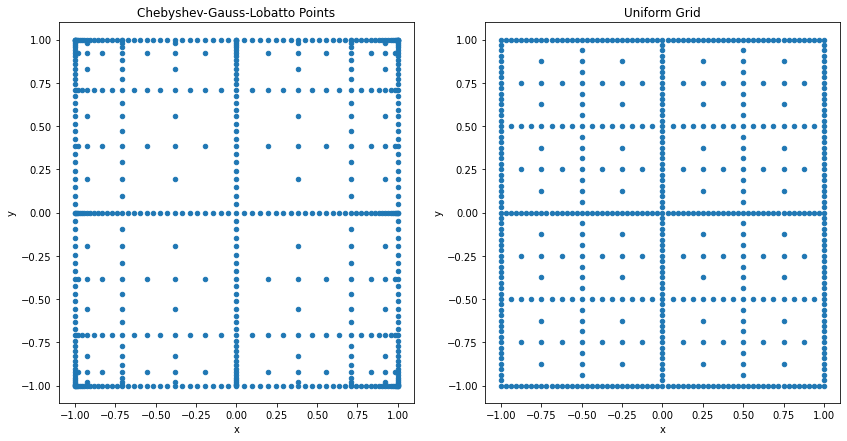

In [2]:
# sparse grid

from pandas import DataFrame, Series
from numpy import cos, pi
import matplotlib.pyplot as plt
import numpy as np

q = 7
d = 2   # below code assumes 2D; d values other than 2 doesn't make sense

### chebyshev spectral method
sem = DataFrame(sum([[(cos(i*pi/2**n), cos(j*pi/2**m)) for i in np.arange(2**n+1) for j in np.arange(2**m+1)] 
                     for m in range(1, q) for n in range(1, q) if d <= m+n <= q], []), columns=['x', 'y']).drop_duplicates()  

### finite difference 
fdm = DataFrame(sum([[(i/2**(n-1)-1, j/2**(m-1)-1) for i in np.arange(2**n+1) for j in np.arange(2**m+1)] 
                     for m in range(1, q) for n in range(1, q) if d <= m+n <= q], []), columns=['x', 'y']).drop_duplicates()  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
sem.plot(kind='scatter', x='x', y='y', ax=ax1)
ax1.set_title('Chebyshev-Gauss-Lobatto Points')

fdm.plot(kind='scatter', x='x', y='y', ax=ax2)
ax2.set_title('Uniform Grid')

interior_pts = sem[(sem['x'] != -1) & (sem['x'] != 1) & (sem['y'] != -1) & (sem['y'] != 1)]

Series({
    'q': q, 
    'd': d, 
    'number of grid points on one boundary': (2**(q-1)+1),
    'number of full grid points': (2**(q-1)+1)**2, 
    'number of sparse grid points': sem.shape[0], 
    'number of full grid interior points': (2**(q-1)-1)**2, 
    'number of sparse grid interior points': interior_pts.shape[0], 
    'ratio number of interior points (sparse/full)': interior_pts.shape[0]/(2**(q-1)-1)**2
})

## Linear Gauss Markov (LGM) Model

* [據說](https://quant.stackexchange.com/questions/14001/how-popular-is-the-linear-gauss-markov-lgm-model)就是 Leif Andersen 11.3.2.6.

## [Copula](https://en.wikipedia.org/wiki/Copula_(probability_theory))

### Definition and Usage

* A $d$-dimensional copula is a CDF defined on $[0, 1]^d$ such that all marginal distributions are Uniform(0, 1)
* Sklar's theorem: Under regularity conditions, any multivariate CDF can be uniquely written in terms of its marginal CDFs and some copula
* Gauss copula in 2D is defined as
\begin{align*}
C_{\rho}(u, v) = \Phi_{\rho}(\Phi^{-1}(u), \Phi^{-1}(v)), 
\end{align*}
where $\Phi$ is the 1D standard normal CDF and $\Phi_{\rho}$ is the bivariate normal CDF with covariance matrix
\begin{align*}
\begin{bmatrix}
1 & \rho \\
\rho & 1 
\end{bmatrix}
\end{align*}
* The copula density is 
\begin{align*}
c_\rho(u, v) = \frac{\partial C_{\rho}}{\partial v\partial v}(u, v) = \frac{\phi_{\rho}(\Phi^{-1}(u), \Phi^{-1}(v))}{\phi(\Phi^{-1}(u))\phi(\Phi^{-1}(v))}, 
\end{align*}
where $\phi$ is the 1D standard normal PDF and $\phi_{\rho}$ is the bivariate normal PDF with the same covariance matrix
* The bivariate CDF 
\begin{align*}
C_{\rho}(F_x(x), F_y(y))
\end{align*}
has marginal CDFs $F_x, F_y$ and Gauss copula correlation $\rho$, and the corresponding PDF is 
\begin{align*}
c_{\rho}(F_x(x), F_y(y))f_X(x)f_Y(y)
\end{align*}

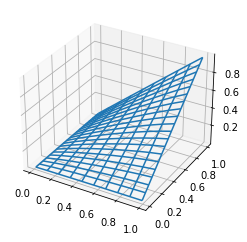

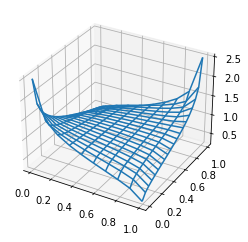

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from scipy.stats import norm, multivariate_normal

def C(u, v, rho):
    '''Bivariate Gauss copula'''
    return multivariate_normal.cdf([norm.ppf(u), norm.ppf(v)], cov=[[1.0, rho], [rho, 1.0]])

def c(u, v, rho):
    '''Bivariate Gauss copula density'''
    return multivariate_normal.pdf([norm.ppf(u), norm.ppf(v)], cov=[[1.0, rho], [rho, 1.0]])/(norm.pdf(norm.ppf(u))*norm.pdf(norm.ppf(v)))

def plot_surf(f, x, y, fillna=0):
    Z = np.array([[f(xi, yi) for xi in x] for yi in y])
    Z[np.isnan(Z)] = fillna
    X = np.array([x for _ in y])
    Y = np.array([y for _ in x]).T
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(X, Y, Z)
    
rho = 0.2
x = np.linspace(0.01, 0.99, 10)
y = np.linspace(0.01, 0.99, 20)
plot_surf(lambda x, y: C(x, y, rho), x, y)
plot_surf(lambda x, y: c(x, y, rho), x, y, fillna=None)

In [7]:
from ipywidgets import interact

@interact(rho=(-0.9, 0.99, 0.1))
def f(rho=0.2):
    x = np.linspace(0.01, 0.99, 10)
    y = np.linspace(0.01, 0.99, 20)
    plot_surf(lambda x, y: C(x, y, rho), x, y)
    plot_surf(lambda x, y: c(x, y, rho), x, y, fillna=None)

interactive(children=(FloatSlider(value=0.2, description='rho', max=0.99, min=-0.9), Output()), _dom_classes=(…

### Simulation

* To simulate from Gauss copula: 
    1. generate normal random variables with the given covariance matrix
    1. plug every number into standard normal CDF so that the marginal distributions are uniform


* To simulate from a joint distribution such that the marginal distribution of $x, y$ are $\chi^2$ and exponential, respectively: 
    1. generate Gauss copula random numbers
    1. plug $x$ values into $\chi^2$ inverse CDF, and $y$ values into exponential inverse CDF
    

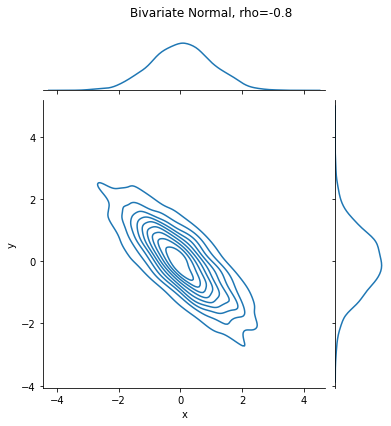

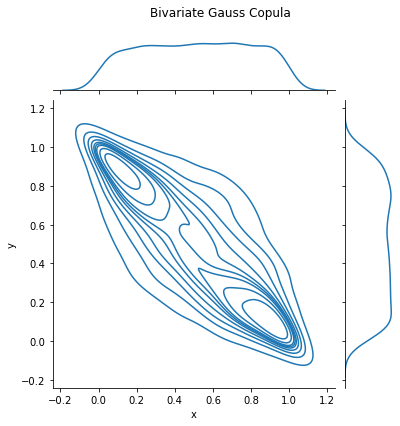

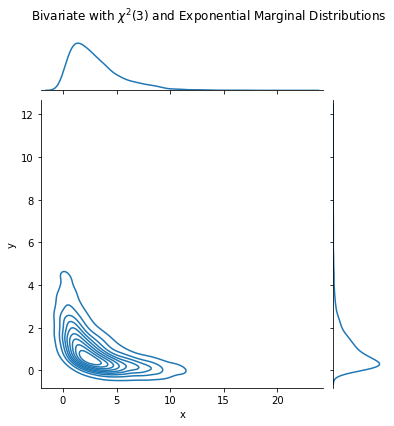

In [13]:
from scipy.stats import norm, multivariate_normal, chi2, expon
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_data(data, title):
    '''jointplot a DataFrame with 'x' and 'y' columns'''
    
    p = sns.jointplot(x='x', y='y', kind='kde', data=data)
    p.fig.suptitle(title)
    p.fig.subplots_adjust(top=0.9, right=0.9)

    
rho = -0.8
n = 2000

np.random.seed(0)
data = DataFrame(multivariate_normal(cov=[[1.0, rho], [rho, 1.0]]).rvs(n), columns=['x', 'y'])
plot_data(data=data, title='Bivariate Normal, rho=-0.8')

data = data.applymap(norm.cdf)
plot_data(data=data, title='Bivariate Gauss Copula')

data['x'] = data['x'].map(chi2(df=3).ppf)
data['y'] = data['y'].map(expon.ppf)
plot_data(data=data, title='Bivariate with $\chi^2(3)$ and Exponential Marginal Distributions')

## Notes on LMM

Let $q(t)$ be the index such that $T_{q(t)-1} \le t < T_{q(t)}$. Then the dynamics of the forward rate $L_n(t) = L(t, T_n, T_{n+1})$ in the spot measure $Q^B$ is
\begin{align*}
dL_n(t) = \sigma_n(t)^T\left(\sum_{j=q(t)}^n\frac{\tau_j\sigma_j(t)}{1+\tau_j L_j(t)} dt + dW^B(t)\right). 
\end{align*}
This is the discrete version of the HJM forward rate dynamics
\begin{align*}
df(t, T) = \sigma(t, T)^T \left(\Sigma(t, T)dt + d \widetilde W_t\right). 
\end{align*}
Adding stochastic volatility, the model is 
\begin{align*}
dz(t) &= \theta(1 - z(t))dt + \eta\sqrt{z(t)}dZ^B(t), \\
dL_n(t) &= \sqrt{z(t)}\phi(L_n(t))\lambda_n(t)^T\left(\sqrt{z(t)}\mu_n(t) dt + dW^B(t)\right), \\
\mu_n(t) &= \sum_{j=q(t)}^n\frac{\tau_j\phi(L_j(t))\lambda_j(t)}{1+\tau_j L_j(t)}. 
\end{align*}

## LMM SV With Non-zero Correlation

Consider one factor normal LMM with SV
\begin{align*}
&dL_n(t) = \sigma_n \sqrt{z(t)}dW^{n+1}(t) = \sigma_n\sqrt{z(t)}\left(\sum_{j=q(t)}^n\frac{\tau_j \sigma_j\sqrt{z(t)}}{1+\tau_jL_j(t)}dt + dW^B(t)\right), \\
&dz(t) = \theta(1-z(t))\,dt + \eta\sqrt{z(t)}\,dZ^B(t), \\
&dZ^B(t)\,dW^B(t) = \rho\,dt. 
\end{align*}
One can write
\begin{align*}
dZ^B(t) = \rho\,dW^B(t) + \sqrt{1-\rho^2}\,d\widetilde W(t)
\end{align*}
for some independent Brownian motion $\widetilde W(t)$. Thus 
\begin{align*}
dz(t) &= \theta(1-z(t))\,dt + \eta\sqrt{z(t)}\,dZ^B(t)\\
&= \theta(1-z(t))\,dt + \eta\sqrt{z(t)}\left(\rho\,dW^B(t) + \sqrt{1-\rho^2}\,d\widetilde W(t)\right)\\
&= \theta(1-z(t))\,dt + \eta\sqrt{z(t)}\left(\rho\left(-\sum_{j=q(t)}^n\frac{\tau_j \sigma_j\sqrt{z(t)}}{1+\tau_jL_j(t)}dt + dW^{n+1}(t)\right) + \sqrt{1-\rho^2}\,d\widetilde W(t)\right)\\
&= \theta(1-\alpha(t)z(t))\,dt + \eta\sqrt{z(t)}\left(\rho\,dW^{n+1}(t) + \sqrt{1-\rho^2}\,d\widetilde W(t)\right)\\
&= \theta(1-\alpha(t)z(t))\,dt + \eta\sqrt{z(t)}\,dZ^{n+1}(t), 
\end{align*}
where $dZ^{n+1}(t)\,dW^{n+1}(t) = \rho\,dt$ and 
\begin{align*}
\alpha(t) = 1+\frac{\eta\rho}{\theta}\sum_{j=q(t)}^n\frac{\tau_j \sigma_j}{1+\tau_jL_j(t)}. 
\end{align*}

## LMM Related Questions

* What's the LIBOR 3M forward rate? 
* Forward rate is a martingale under what measure? What's its corresponding numeraire? 
* What about futures rate? What's its corresponding numeraire? 
* $L_n$ dynamics under $T_n$ forward measure? (1 term in the BGM drift term)
* Describe PCA for dimension reduction in BGM. What data do you use? 
* Which one in the picture is the 1st PC, which one is 2nd? 

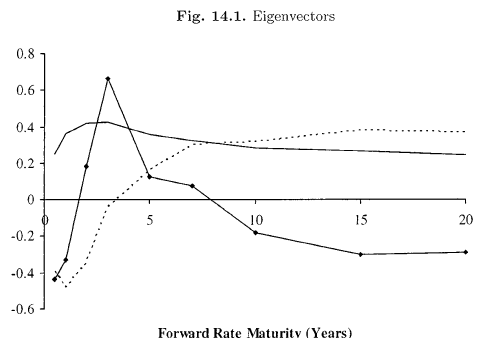


* What is skew? How does BGM capture skew? 
* What's that you calibrate in BGM? 
* Where is today's volatility hump in BGM vol grid? 
* What are your calibration instruments? How do you price swaptions? In a high level, describe how the approximation is derived
* Describe how to price a vanilla swaption using a calibrated BGM model with MC
* What's the Longstaff-Schwartz algorithm? 
* What's SOFR
* 3M SOFR futures Sept 2022 contract -- term rate from what window? When is the last trade date? When is the fixing date? 
* How to modify BGM volatility to model SOFR index? 
* How to modify BGM measure to model SOFR index? (Extended bond price: buy $T$-bond and reinvest in MMA after $T$)
* How does SABR handle negative rates? What's a reasonable way to determine shift? 
* SABR model: how does each parameter control the shape of the implied vol? 

## HW2F Summary

Let
\begin{align*}
h(t) &= \begin{bmatrix}
e^{-\kappa_1 t}\\
e^{-\kappa_2 t}
\end{bmatrix}_{2\times 1}, \\
g(t) &= \begin{bmatrix}
\sigma_1\sqrt{1-\rho^2} e^{\kappa_1 t} & 0\\
\sigma_1\rho e^{\kappa_1 t} & \sigma_2 e^{\kappa_2 t}
\end{bmatrix}_{2\times 2}. 
\end{align*}
The HJM forward rate vol is
\begin{align*}
\sigma(t, T) = g(t)h(T) = \begin{bmatrix}
\sigma_1\sqrt{1-\rho^2} e^{-\kappa_1 (T-t)} \\
\sigma_1\rho e^{-\kappa_1 (T-t)} + \sigma_2 e^{-\kappa_2 (T-t)}
\end{bmatrix}_{2\times 1}, 
\end{align*}
or, if allowing a correlation $\rho$ between the two Brownian motions in the forward rate process, 
\begin{align*}
\sigma^*(t, T) = \begin{bmatrix}
\sigma_1 e^{-\kappa_1 (T-t)} \\
\sigma_2 e^{-\kappa_2 (T-t)}
\end{bmatrix}_{2\times 1}. 
\end{align*}



Let $H(t) = \operatorname{diag}(h(t))$ and 
\begin{align*}
\sigma_x &= g(t)H(t) = \begin{bmatrix}
\sigma_1\sqrt{1-\rho^2} & 0\\
\sigma_1\rho & \sigma_2 
\end{bmatrix}_{2\times 2}, \\
\sigma_x^* &= \begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}_{2\times 2}.
\end{align*}

Let 
\begin{align*}
\kappa &= \begin{bmatrix}
\kappa_1 & 0\\
0 & \kappa_2
\end{bmatrix}_{2\times 2}.
\end{align*}


Then the short rate process is $r(t) = f(0, t) + x_1(t) + x_2(t) = f(0, t) + x(t)\mathbf 1$, where $x(0) = y(0) = 0$, 
\begin{align*}
\begin{cases}
dx(t) = (y(t)\mathbf 1 - \kappa x(t))dt + \sigma_x^T dW(t)\\
dy(t) = (\sigma_x^T\sigma_x - \kappa y(t) - y(t)\kappa) dt \\
dW_1(t)dW_2(t) = 0
\end{cases}, 
\end{align*}
and the covariance matrix is 
\begin{align*}
\sigma_x^T\sigma_x = \begin{bmatrix}
\sigma_1^2 & \rho\sigma_1\sigma_2 \\
\rho\sigma_1\sigma_2 & \sigma_2^2
\end{bmatrix}_{2\times 2}.
\end{align*}
The ODE of $y(t)$ can be solved explicitly to obtain
\begin{align*}
y(t) &= H(t)\left(\int_0^t g(s)^Tg(s)\,ds\right)H(t)\\
&= \begin{bmatrix}
\frac{\sigma_1^2\left(1-e^{-2\kappa_1 t}\right)}{2\kappa_1} & \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2}\\
\frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} & \frac{\sigma_2^2\left(1-e^{-2\kappa_2 t}\right)}{2\kappa_2}
\end{bmatrix}_{2\times 2}.
\end{align*}
Alternatively, one can write
\begin{align*}
\begin{cases}
dx(t) = (y(t)\mathbf 1 - \kappa x(t))dt + \sigma^*_x dW^*(t) \\
dW_1^*(t)dW_2^*(t) = \rho dt
\end{cases}, 
\end{align*}
or more explicitly, 
\begin{align*}
\begin{cases}
dx_1(t) = \left(\frac{\sigma_1^2\left(1-e^{-2\kappa_1 t}\right)}{2\kappa_1} + \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} - \kappa_1 x_1(t)\right)dt + \sigma_1 dW^*_1(t) \\
dx_2(t) = \left(\frac{\sigma_2^2\left(1-e^{-2\kappa_2 t}\right)}{2\kappa_2} + \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} - \kappa_2 x_2(t)\right)dt + \sigma_2 dW^*_2(t) \\
dW_1^*(t)dW_2^*(t) = \rho dt
\end{cases}. 
\end{align*}




Let 
\begin{align*}
M(t, T) &= H(T)H(t)^{-1}\mathbf 1 = \begin{bmatrix}
e^{-\kappa_1(T-t)}\\
e^{-\kappa_2(T-t)}
\end{bmatrix}_{2\times 1}, \\
G(t, T) &= \int_t^TM(t, u)\,du = \begin{bmatrix}
\frac{1-e^{-\kappa_1(T-t)}}{\kappa_1}\\
\frac{1-e^{-\kappa_2(T-t)}}{\kappa_2}
\end{bmatrix}_{2\times 1}. 
\end{align*}
Then the forward rate process and the zero-coupon bond price are 
\begin{align*}
f(t, T) &= f(0, T) + M(t, T)^T(x(t) + y(t)G(t, T)), \\
P(t, T) &=\frac{P(0, T)}{P(0, t)}\exp\left(-G(t, T)^Tx(t) - \frac12G(t, T)^Ty(t)G(t, T)\right), 
\end{align*}
respectively. Note that since $G$ and $M$ are both functions of $T-t$, the dynamics of $f(t, T)$ and $P(t, T)$ are stationary. 


The risk-neutral process of $P(t, T)$ is log-normal
\begin{align*}
\frac{dP(t, T)}{P(t, T)} &= r(t)dt - (\sigma_x G(t, T))^T dW(t)\\
&= r(t)dt - (\sigma^*_x G(t, T))^T dW^*(t). 
\end{align*}
That is, the HJM bond price vol is $\Sigma(t, T) = \sigma_x G(t, T)$, or 
\begin{align*}
\Sigma^*(t, T) = \sigma^*_x G(t, T) = \begin{bmatrix}
\frac{\sigma_1}{\kappa_1}\left(1-e^{-\kappa_1(T-t)}\right)\\
\frac{\sigma_2}{\kappa_2}\left(1-e^{-\kappa_2(T-t)}\right)
\end{bmatrix}_{2\times 1}
\end{align*}
if allowing a correlation $\rho$ between the two Brownian motions in the process. 

## HW2F Summary New Notation

The notation here is more intuitive than Leif Andersen. 
Let
\begin{align*}
h(t) &= \begin{bmatrix}
e^{-\kappa_1 t}\\
e^{-\kappa_2 t}
\end{bmatrix}_{2\times 1}, \\
H(t) &= \operatorname{diag}(h(t)) = \begin{bmatrix}
e^{-\kappa_1 t} & 0\\
0 & e^{-\kappa_2 t}
\end{bmatrix}_{2\times 2}, \\
\sigma_x^* &= \begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}_{2\times 2}, \\
R &= \begin{bmatrix}
1 & \rho\\
\rho & 1
\end{bmatrix}_{2\times 2} = DD^{\mathsf T}, \\
D &= \begin{bmatrix}
1 & 0\\
\rho & \sqrt{1-\rho^2}
\end{bmatrix}_{2\times 2}, \\
g(t) &= D^{\mathsf T} \sigma^*_x H(t)^{-1}. 
\end{align*}
The HJM forward rate vol is
\begin{align*}
\sigma(t, T) = g(t)h(T) = D^{\mathsf T}\begin{bmatrix}
\sigma_1 e^{-\kappa_1 (T-t)} \\
\sigma_2 e^{-\kappa_2 (T-t)}
\end{bmatrix}_{2\times 1}, 
\end{align*}
or, if allowing a correlation $\rho$ between the two driving Brownian motions of the forward rate process, just
\begin{align*}
\sigma^*(t, T) = \begin{bmatrix}
\sigma_1 e^{-\kappa_1 (T-t)} \\
\sigma_2 e^{-\kappa_2 (T-t)}
\end{bmatrix}_{2\times 1}. 
\end{align*}



Let
\begin{align*}
\sigma_x &= g(t)H(t) = \begin{bmatrix}
\sigma_1 & \sigma_2\rho\\
0 & \sigma_2 \sqrt{1-\rho^2}
\end{bmatrix}_{2\times 2}.\\
\kappa &= \begin{bmatrix}
\kappa_1 & 0\\
0 & \kappa_2
\end{bmatrix}_{2\times 2}.
\end{align*}


Then the short rate process is $r(t) = f(0, t) + x_1(t) + x_2(t) = f(0, t) + x(t)\mathbf 1$, where $x(0) = y(0) = 0$, 
\begin{align*}
\begin{cases}
dx(t) = (y(t)\mathbf 1 - \kappa x(t))dt + \sigma_x^{\mathsf T} dW(t)\\
dy(t) = (\sigma_x^{\mathsf T}\sigma_x - \kappa y(t) - y(t)\kappa) dt \\
dW_1(t)dW_2(t) = 0
\end{cases}, 
\end{align*}
and the covariance matrix is 
\begin{align*}
\sigma_x^{\mathsf T}\sigma_x = \begin{bmatrix}
\sigma_1^2 & \rho\sigma_1\sigma_2 \\
\rho\sigma_1\sigma_2 & \sigma_2^2
\end{bmatrix}_{2\times 2}.
\end{align*}
The ODE of $y(t)$ can be solved explicitly to obtain
\begin{align*}
y(t) &= H(t)\left(\int_0^t g(s)^{\mathsf T}g(s)\,ds\right)H(t)\\
&= \begin{bmatrix}
\frac{\sigma_1^2\left(1-e^{-2\kappa_1 t}\right)}{2\kappa_1} & \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2}\\
\frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} & \frac{\sigma_2^2\left(1-e^{-2\kappa_2 t}\right)}{2\kappa_2}
\end{bmatrix}_{2\times 2}.
\end{align*}
Alternatively, one can write
\begin{align*}
\begin{cases}
dx(t) = (y(t)\mathbf 1 - \kappa x(t))dt + \sigma^*_x dW^*(t) \\
dW_1^*(t)dW_2^*(t) = \rho dt
\end{cases}, 
\end{align*}
or more explicitly, 
\begin{align*}
\begin{cases}
dx_1(t) = \left(\frac{\sigma_1^2\left(1-e^{-2\kappa_1 t}\right)}{2\kappa_1} + \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} - \kappa_1 x_1(t)\right)dt + \sigma_1 dW^*_1(t) \\
dx_2(t) = \left(\frac{\sigma_2^2\left(1-e^{-2\kappa_2 t}\right)}{2\kappa_2} + \frac{\rho\sigma_1\sigma_2\left(1-e^{-(\kappa_1 + \kappa_2) t}\right)}{\kappa_1 + \kappa_2} - \kappa_2 x_2(t)\right)dt + \sigma_2 dW^*_2(t) \\
dW_1^*(t)dW_2^*(t) = \rho dt
\end{cases}. 
\end{align*}


Let 
\begin{align*}
M(t, T) &= H(T)H(t)^{-1}\mathbf 1 = \begin{bmatrix}
e^{-\kappa_1(T-t)}\\
e^{-\kappa_2(T-t)}
\end{bmatrix}_{2\times 1}, \\
G(t, T) &= \int_t^TM(t, u)\,du = \begin{bmatrix}
\frac{1-e^{-\kappa_1(T-t)}}{\kappa_1}\\
\frac{1-e^{-\kappa_2(T-t)}}{\kappa_2}
\end{bmatrix}_{2\times 1}. 
\end{align*}
Then the forward rate process and the zero-coupon bond price are 
\begin{align*}
f(t, T) &= f(0, T) + M(t, T)^{\mathsf T}(x(t) + y(t)G(t, T)), \\
P(t, T) &=\frac{P(0, T)}{P(0, t)}\exp\left(-G(t, T)^{\mathsf T}x(t) - \frac12G(t, T)^{\mathsf T}y(t)G(t, T)\right), 
\end{align*}
respectively. Note that since $G$ and $M$ are both functions of $T-t$, the dynamics of $f(t, T)$ and $P(t, T)$ are stationary. 


The risk-neutral process of $P(t, T)$ is log-normal
\begin{align*}
\frac{dP(t, T)}{P(t, T)} &= r(t)dt - (\sigma_x G(t, T))^{\mathsf T} dW(t)\\
&= r(t)dt - (\sigma^*_x G(t, T))^{\mathsf T} dW^*(t). 
\end{align*}
That is, the HJM bond price vol is $\Sigma(t, T) = \sigma_x G(t, T)$, or 
\begin{align*}
\Sigma^*(t, T) = \sigma^*_x G(t, T) = \begin{bmatrix}
\frac{\sigma_1}{\kappa_1}\left(1-e^{-\kappa_1(T-t)}\right)\\
\frac{\sigma_2}{\kappa_2}\left(1-e^{-\kappa_2(T-t)}\right)
\end{bmatrix}_{2\times 1}
\end{align*}
if allowing a correlation $\rho$ between the two Brownian motions in the process. The following identities hold: 
\begin{align*}
\sigma_x^* M &= \sigma^*(t, T), \\
\sigma_x^* G &= \Sigma^*(t, T).
\end{align*}

We note that the $g(t)$ being a constant matrix times $H(t)^{-1}$ makes the forward rate vol time stationary. In a HW1F with time stationary forward rate vol this is necessary, because if 
\begin{align*}
\sigma(t, T) = g(t)h(T) = f(T-t)
\end{align*}
for some function $f$, then we can write 
\begin{align*}
\sigma(t, t) = g(t)h(t) = f(0)
\end{align*}
which is a constant. This constant is in fact the short rate vol which we denote by $\sigma_r$, and we must have $g(t) = \sigma_r h(t)^{-1}$. 

## Covariance of a Stochastic Vector Process

Consider an $m$-factor model with $N$ state variables in a vector $\vec X_t$ which satisfies 
\begin{align*}
d\vec X_t = O(dt) + \sigma^{\mathsf T}\,d\vec W_t, 
\end{align*}
where $\sigma$ is an $m\times N$ matrix and $\vec W_t$ is the standard (independent) Brownian motion. Then the $N\times N$ instantaneous covariance matrix of $X_t$ is
\begin{align*}
\text{cov}(d\vec X_t) = \left(\sigma^{\mathsf T}\sigma\right)\,dt.
\end{align*}
In general, if 
\begin{align*}
d\vec X_t = O(dt) + \sigma^{\mathsf T}\,d\vec Z_t
\end{align*}
and $\text{cov}(d\vec Z_t) = R\,dt$ then 
\begin{align*}
\text{cov}(d\vec X_t) = \left(\sigma^{\mathsf T}R\sigma\right)\,dt.
\end{align*}
In particular, if $\vec Z_t = \vec W^*_t$ is a correlated Brownian motion with instantaneous correlation matrix $R$, then the instantaneous covariance matrix of $X_t$ is given by the same formula. 


Now consider the special case $N=1$, where $X_t$ is simply a scalar stochastic process and $\sigma$ is an $m$-dimensional vector. If 
\begin{align*}
dX_t = O(dt) + \sigma^{\mathsf T}\,d\vec W_t, 
\end{align*}
where $\vec W_t$ is the standard (independent) Brownian motion in $m$-dimensions, then
\begin{align*}
\text{Var}(dX_t) = \left(\sigma^{\mathsf T}\sigma\right)\,dt. 
\end{align*}
If instead 
\begin{align*}
dX_t = O(dt) + \sigma^{\mathsf T}\,d\vec Z_t, 
\end{align*}
where $\vec Z_t$ has instantaneous covariance matrix $R$ (for example a correlated Brownian motion), then 
\begin{align*}
\text{Var}(dX_t) = \left(\sigma^{\mathsf T}R\sigma\right)\,dt. 
\end{align*}


An application is to compute the variance of the instantaneous forward curve in the HJM framework for a specific $T$: 
\begin{align*}
df(t, T) &= \sigma(t, T)^{\mathsf T}(\Sigma(t, T)\,dt + d{\widetilde W}(t)), \\
\text{Var}(df(t, T)) &= \sigma(t, T)^{\mathsf T}\sigma(t, T)\,dt. 
\end{align*}

## Covariance of Instantaneous Forward Curve in Multi-Dimensional HJM

Consider an $m$-factor HJM model
\begin{align*}
df(t, T) &= \sigma(t, T)^{\mathsf T}(\Sigma(t, T)\,dt + d\widetilde W(t)) \\
&= {\sigma^*(t, T)}^{\mathsf T}(\Sigma^*(t, T)\,dt + d{\widetilde W}^*(t)), 
\end{align*}
where 
\begin{align*}
&\text{$\sigma(t, T)$ is an $m$-dimensional volatility vector, }\\
&\text{$\widetilde W(t)$ is the $m$-dimensional standard (independent) Brownian motion, }
\end{align*}
while
\begin{align*}
&\text{$\sigma^*(t, T)$ is an $N$-dimensional volatility vector, }\\
&\text{$\widetilde W^*(t)$ is $N$-dimensional with correlation matrix $R$. }
\end{align*}
If we write $R = DD^{\mathsf T}$ with $D$ an $N\times m$ matrix then the following identity holds
\begin{align*}
\sigma(t, T) = D^{\mathsf T} \sigma^*(t, T). 
\end{align*}
Modeling the volatility vector $\sigma^*(t, T)$ and the correlation $R$ separately is a simpler way than modeling the matrix $\sigma(t, T)$ directly. 


Let 
\begin{align*}
\sigma^*(t, T) = \begin{pmatrix}
\sigma_1^*(t, T)\\
\sigma_2^*(t, T)\\
\vdots\\
\sigma_N^*(t, T)\\
\end{pmatrix}.
\end{align*}
Most likely (?) it can be shown that if all $\sigma_j^*(t, T)$ are separable then the short rate process is Markovian. Let $S = \operatorname{diag}(\sigma^*(t, T))$. The factor covariance matrix is $SRS$. 


To compute the forward rates covariance matrix, consider the forward rates in $M$ tenors $\delta_1, \delta_2, \ldots, \delta_M$: 
\begin{align*}
df(t, t+\delta_1) &= {\sigma^*(t, t+\delta_1)}^{\mathsf T}(\Sigma(t, t+\delta_1)\,dt + d{\widetilde W}^*(t)), \\
df(t, t+\delta_2) &= {\sigma^*(t, t+\delta_2)}^{\mathsf T}(\Sigma(t, t+\delta_2)\,dt + d{\widetilde W}^*(t)), \\
&\qquad\qquad\qquad\vdots\\
df(t, t+\delta_M) &= {\sigma^*(t, t+\delta_M)}^{\mathsf T}(\Sigma(t, t+\delta_M)\,dt + d{\widetilde W}^*(t)). 
\end{align*}
Denote $f_j(t) = f(t, t+\delta_j), ~\vec f(t) = (f_1(t), f_2(t), \ldots, f_M(t))^{\mathsf T}$. Then we can write the above in matrix form as 
\begin{align*}
d\vec f(t) &= O(dt) + \begin{pmatrix}
\frac{\quad}{\quad} & {\sigma^*(t, t+\delta_1)}^{\mathsf T} & \frac{\quad}{\quad}\\
\frac{\quad}{\quad} & {\sigma^*(t, t+\delta_2)}^{\mathsf T} & \frac{\quad}{\quad}\\
&\vdots&\\
\frac{\quad}{\quad} & {\sigma^*(t, t+\delta_M)}^{\mathsf T} & \frac{\quad}{\quad}\\
\end{pmatrix}_{M\times N}\,d{\widetilde W}^*(t)\\
&= O(dt) + \begin{pmatrix}
\sigma_1^*(t, t+\delta_1) & \sigma_2^*(t, t+\delta_1) & \cdots & \sigma_N^*(t, t+\delta_1)\\
\sigma_1^*(t, t+\delta_2) & \sigma_2^*(t, t+\delta_2) & \cdots & \sigma_N^*(t, t+\delta_2)\\
\vdots & \vdots & \ddots & \vdots \\
\sigma_1^*(t, t+\delta_M) & \sigma_2^*(t, t+\delta_M) & \cdots & \sigma_N^*(t, t+\delta_M)
\end{pmatrix}_{M\times N}\,d{\widetilde W}^*(t). 
\end{align*}
We further denote the $M\times N$ volatility matrix by $(\sigma_f^*)^{\mathsf T}$. 
The forward rates covariance matrix is then given by $(\sigma_f^*)^{\mathsf T}R\sigma_f^*$. 
Preferably the entire matrix is time stationary (function of $\delta_j$). A sufficient condition to achieve that is for each element $\sigma_i^*(t, T)$ to be time stationary. Given the property of HW1F that the only possible time stationary separable vol is $\sigma_re^{-k(T-t)}$, we know each $\sigma_i^*(t, T)$ must have the same form. This leads to HWmF. 


Each element $\sigma_i^*(t, T)$ being time stationary is simply a sufficient condition for the forward rate covariance to be time stationary, not necessary. Is it possible there exists a model with time stationary forward rate covariance but each element $\sigma_i^*(t, T)$ is not time stationary? 

## Covariance of Instantaneous Forward Curve in HWmF

Consider a 3-factor model. Recall that 
\begin{align*}
f(t, T) = f(0, T) + M(t, T)^{\mathsf T}\left(x(t) + y(t) G(t, T)\right), 
\end{align*}
where 
\begin{align*}
M(t, T) &= H(T)H(t)^{-1}\mathbf 1 = \begin{bmatrix}
e^{-\kappa_1(T-t)}\\
e^{-\kappa_2(T-t)}\\
e^{-\kappa_3(T-t)}
\end{bmatrix}_{3\times 1}, \\
G(t, T) &= \int_t^TM(t, u)\,du = \begin{bmatrix}
\frac{1-e^{-\kappa_1(T-t)}}{\kappa_1}\\
\frac{1-e^{-\kappa_2(T-t)}}{\kappa_2}\\
\frac{1-e^{-\kappa_2(T-t)}}{\kappa_2}
\end{bmatrix}_{3\times 1}. 
\end{align*}
Plug in $T=t+\delta$ to write
\begin{align*}
f(t, t+\delta) &= f(0, t+\delta) + M(t, t+\delta)^{\mathsf T}\left(x(t) + y(t) G(t, t+\delta)\right), \\
&= f(0, t+\delta) + \begin{bmatrix}e^{-\kappa_1\delta} & e^{-\kappa_2\delta} & e^{-\kappa_3\delta}\end{bmatrix}\left(x(t) + y(t) G(t, t+\delta)\right).
\end{align*}
This is true for all $\delta$, so we can write
\begin{align*}
f(t, t+\delta_1) &= f(0, t+\delta_1) + \begin{bmatrix}e^{-\kappa_1\delta_1} & e^{-\kappa_2\delta_1} & e^{-\kappa_3\delta_1}\end{bmatrix}\left(x(t) + y(t) G(t, t+\delta_1)\right), \\
f(t, t+\delta_2) &= f(0, t+\delta_2) + \begin{bmatrix}e^{-\kappa_1\delta_2} & e^{-\kappa_2\delta_2} & e^{-\kappa_3\delta_2}\end{bmatrix}\left(x(t) + y(t) G(t, t+\delta_2)\right), \\
&\vdots\\
f(t, t+\delta_M) &= f(0, t+\delta_M) + \begin{bmatrix}e^{-\kappa_1\delta_M} & e^{-\kappa_2\delta_M} & e^{-\kappa_3\delta_M}\end{bmatrix}\left(x(t) + y(t) G(t, t+\delta_M)\right). 
\end{align*}
Denote $f_j(t) = f(t, t+\delta_j), ~\vec f(t) = (f_1(t), f_2(t), \ldots, f_M(t))^{\mathsf T}$ and write the above in vector differential form, we obtain
\begin{align*}
d\vec f(t) = H_f^{\mathsf T} dx(t) + O(dt), 
\end{align*}
where 
\begin{align*}
H_f^{\mathsf T} = \begin{bmatrix}
e^{-\kappa_1\delta_1} & e^{-\kappa_2\delta_1} & e^{-\kappa_3\delta_1}\\
e^{-\kappa_1\delta_2} & e^{-\kappa_2\delta_2} & e^{-\kappa_3\delta_2}\\
&\vdots&\\
e^{-\kappa_1\delta_M} & e^{-\kappa_2\delta_M} & e^{-\kappa_3\delta_M}\\
\end{bmatrix}_{M\times 3}. 
\end{align*}
The $H_f^{\mathsf T}$ matrix is denoted by $H^f(0) = H^f(t)H(t)^{-1}$ in Leif Andersen p.577. Given the lemmas in the previous section, it is easy to compute the $M\times M$ instantaneous covariance matrix of the forward curve $\vec f(t)$ to be 
\begin{align*}
H_f^{\mathsf T} R H_f, 
\end{align*}
where $R$ is the $3\times 3$ factor covariance matrix in HW3F, denoted by $\sigma_x^{\mathsf T}\sigma_x$ above. 

## HW2F PCA

Let $X$ be a matrix with forward rate daily changes on each row. Then the forward curve sample covariance matrix is 
\begin{align*}
\frac{1}{n}X^{\mathsf T}X. 
\end{align*}
A singular value decomposition of $X$ gives
\begin{align*}
X = USV^{\mathsf T} = TV^{\mathsf T}, 
\end{align*}
where the column vectors of $V$ are the principal components (PCs) and $T$ is a matrix of PC scores. 
Thus the covariance matrix is 
\begin{align*}
\frac{1}{n}X^{\mathsf T}X = VSU^{\mathsf T} USV^{\mathsf T} = V\left(\frac{S^2}{n}\right)V^{\mathsf T}.
\end{align*}
That is, a decomposition of the covariance matrix gives us the PCs. 


We have shown the forward rate covariance matrix in HW2F to be 
\begin{align*}
H_f^{\mathsf T} R H_f, 
\end{align*}
where 
\begin{align*}
H_f = 
\begin{bmatrix}
e^{-\kappa_1\delta_1} & e^{-\kappa_1\delta_2} & \cdots & e^{-\kappa_1\delta_M}\\
e^{-\kappa_2\delta_1} & e^{-\kappa_2\delta_2} & \cdots & e^{-\kappa_2\delta_M}
\end{bmatrix}_{M\times 2}. 
\end{align*}
From now on we denote by $h_1^{\mathsf T}$ and $h_2^{\mathsf T}$ the $M$-dimensional row vectors of $H_f$ and write
\begin{align*}
H_f = 
\begin{bmatrix}
\frac{\qquad}{\qquad} & h_1 & \frac{\qquad}{\qquad}\\
\frac{\qquad}{\qquad} & h_2 & \frac{\qquad}{\qquad}\\
\end{bmatrix}_{M\times 2}. 
\end{align*}
We can rewrite the covariance matrix as
\begin{align*}
&H_f^{\mathsf T} \begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}
\begin{bmatrix}
1 & \rho\\
\rho & 1
\end{bmatrix}
\begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}
H_f \\
=&
H_f^{\mathsf T} \begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}
\begin{bmatrix}
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}\\
-\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}\\
\end{bmatrix}
\begin{bmatrix}
1-\rho & 0\\
0 & 1+\rho
\end{bmatrix}
\begin{bmatrix}
\frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}}\\
\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}\\
\end{bmatrix}
\begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}
H_f. 
\end{align*}
Thus
\begin{align*}
\frac{S}{\sqrt n}V^{\mathsf T} &= 
\begin{bmatrix}
\sqrt{\frac{1-\rho}{2}} & 0\\
0 & \sqrt{\frac{1+\rho}{2}}
\end{bmatrix}
\begin{bmatrix}
1 & -1\\
1 & 1
\end{bmatrix}
\begin{bmatrix}
\sigma_1 & 0\\
0 & \sigma_2
\end{bmatrix}
\begin{bmatrix}
\frac{\qquad}{\qquad} & h_1 & \frac{\qquad}{\qquad}\\
\frac{\qquad}{\qquad} & h_2 & \frac{\qquad}{\qquad}\\
\end{bmatrix}_{M\times 2}\\
&=
\begin{bmatrix}
\sqrt{\frac{1-\rho}{2}} & 0\\
0 & \sqrt{\frac{1+\rho}{2}}
\end{bmatrix}
\begin{bmatrix}
\frac{\qquad}{\qquad} & \sigma_1 h_1  - \sigma_2 h_2 & \frac{\qquad}{\qquad}\\
\frac{\qquad}{\qquad} & \sigma_1 h_1  + \sigma_2 h_2 & \frac{\qquad}{\qquad}\\
\end{bmatrix}_{M\times 2}, 
\end{align*}
so PC1 and PC2 are 
\begin{align*}
\frac{\sigma_1 h_1  - \sigma_2 h_2}{\lVert \sigma_1 h_1  - \sigma_2 h_2\rVert}, \qquad \frac{\sigma_1 h_1  + \sigma_2 h_2}{\lVert \sigma_1 h_1  + \sigma_2 h_2\rVert}, 
\end{align*}
respectively, 
while their corresponding score standard deviations are
\begin{align*}
\sqrt{\frac{1-\rho}{2}}\lVert \sigma_1 h_1 - \sigma_2 h_2\rVert, \qquad\sqrt{\frac{1+\rho}{2}} \lVert \sigma_1 h_1 + \sigma_2 h_2\rVert, 
\end{align*}
respectively. A well known property of HW2F is that $\rho$ needs to be close to -1 to capture volatility hump. Consistently, here $\rho$ also needs to be close to -1 for PC1 score standard deviations to be much larger than PC2's. 

Writing as a continuous function of $\tau$, PC1 is scaled
\begin{align*}
\sigma_1e^{-\kappa_1\tau} - \sigma_2e^{-\kappa_2\tau}
\end{align*}
and PC2 is scaled 
\begin{align*}
\sigma_1e^{-\kappa_1\tau} + \sigma_2e^{-\kappa_2\tau}. 
\end{align*}
For PC1 to be close to a flat function, we must have $\kappa_1 \approx \kappa_2$, $\sigma_1 \approx \sigma_2$, or $\kappa_1$ and $\kappa_2$ both tiny.  


## HW1F Summary

Let $h(t) = e^{-\kappa t}, g(t) = \sigma e^{\kappa t}$. 
The HJM forward rate vol is
\begin{align*}
\sigma(t, T) = g(t)h(T) = \sigma e^{-\kappa (T-t)}.
\end{align*}

The short rate process is $r(t) = f(0, t) + x(t)$, where $x(0) = y(0) = 0$, 
\begin{align*}
\begin{cases}
dx(t) = (y(t) - \kappa x(t))dt + \sigma dW(t)\\
dy(t) = (\sigma^2 - 2\kappa y(t)) dt
\end{cases}.
\end{align*}
The ODE of $y(t)$ can be solved explicitly to obtain
\begin{align*}
y(t) &= h^2(t)\int_0^t g^2(s)\,ds = \frac{\sigma^2\left(1-e^{-2\kappa t}\right)}{2\kappa}. 
\end{align*}
Let 
\begin{align*}
M(t, T) &= h(T)h(t)^{-1} = e^{-\kappa(T-t)}, \\
G(t, T) &= \int_t^TM(t, u)\,du = \frac{1-e^{-\kappa(T-t)}}{\kappa}.
\end{align*}
Note that 
\begin{align*}
\sigma M(t, T) &= \sigma(t, T) = \sigma e^{-\kappa(T-t)}, \\
\sigma G(t, T) &= \Sigma(t, T) = \frac{\sigma\left(1-e^{-\kappa(T-t)}\right)}{\kappa}
\end{align*}
are HJM forward rate vol and bond price vol, respectively. 
The forward rate process and the zero-coupon bond price in HW1F are 
\begin{align*}
f(t, T) &= f(0, T) + M(t, T)(x(t) + y(t)G(t, T)), \\
P(t, T) &=\frac{P(0, T)}{P(0, t)}\exp\left(-G(t, T)x(t) - \frac12G^2(t, T)y(t)\right), 
\end{align*}
respectively. Note that since $G$ and $M$ are both functions of $T-t$, the dynamics of $f(t, T)$ and $P(t, T)$ are stationary. More explicitly, one can write $r(t) = f(0, t) + x(t)$, $x(0) = 0$, 
\begin{align*}
dx(t) &= \left(\frac{\sigma^2\left(1-e^{-2\kappa t}\right)}{2\kappa} - \kappa x(t)\right)dt + \sigma dW(t), \\
f(t, T) &= f(0, T) + e^{-\kappa(T-t)}\left(x(t) + \frac{\sigma^2\left(1-e^{-2\kappa t}\right)\left(1-e^{-\kappa(T-t)}\right)}{2\kappa^2}\right), \\
P(t, T) &=\frac{P(0, T)}{P(0, t)}\exp\left(-\frac{1-e^{-\kappa(T-t)}}{\kappa}x(t) - \frac{\sigma^2\left(1-e^{-2\kappa t}\right)\left(1-e^{-\kappa(T-t)}\right)^2}{4\kappa^3}\right). 
\end{align*}



The risk-neutral process of $P(t, T)$ is log-normal
\begin{align*}
\frac{dP(t, T)}{P(t, T)} &= r(t)dt - \sigma G(t, T) dW(t).
\end{align*}

## Replication Formula

Note that
\begin{align*}
f(S) &= f(K_0) + \int_{K_0}^S f'(K)\,dK\\
&= f(K_0) -\int_{\mathbb R} 1_{\{S\le K\le K_0\}} f'(K)\,dK + \int_{\mathbb R} 1_{\{K_0\le K\le S\}} f'(K)\,dK, 
\end{align*}
where the last two terms cannot to be both nonzero. 
The first term is nonzero only if $K_0> S$ and 
the second term is nonzero only if $K_0< S$. We can rewrite
\begin{align*}
f(S) =& ~f(K_0) -\int_0^{K_0} 1_{\{K\ge S\}} f'(K)\,dK + \int_{K_0}^\infty 1_{\{K\le S\}} f'(K)\,dK\\
=& ~f(K_0) + \int_0^{K_0} (K-S)^+ f''(K)\,dK + \int_{K_0}^\infty (S-K)^+ f''(K)\,dK\\
&-\left[(K-S)^+ f'(K)\right]_{K=0}^{K=K_0} -\left[(S-K)^+ f'(K)\right]_{K=K_0}^{K=\infty}\\
%=& ~f(K_0) + \int_0^{K_0} (K-S)^+ f''(K)\,dK + \int_{K_0}^\infty (S-K)^+ f''(K)\,dK\\
%& - (K_0 - S)^+f'(K_0) + (S-K_0)^+ f'(K_0)\\
=& ~f(K_0) + (S-K_0) f'(K_0) + \int_0^{K_0} (K-S)^+ f''(K)\,dK + \int_{K_0}^\infty (S-K)^+ f''(K)\,dK. 
\end{align*}
Now plug in $S=S_T$ a random varaible and take expectation to obtain
\begin{align*}
E[f(S_T)] = f(K_0) + f'(K_0) E[S_T-K_0] + \int_0^{K_0} E[(K-S_T)^+] f''(K)\,dK + \int_{K_0}^\infty E[(S_T-K)^+] f''(K)\,dK. 
\end{align*}
If we choose to set $K_0 = E[S_T]$ (ATMF), the second term on the right hand side vanishes and we have 
\begin{align*}
E[f(S_T)] = f(E[S_T]) + \int_0^{K_0} E[(K-S_T)^+] f''(K)\,dK + \int_{K_0}^\infty E[(S_T-K)^+] f''(K)\,dK. 
\end{align*}

## Time Integral of Brownian Motion and Brownian Bridge

The integral form of $d(tW_t) = W_tdt + tdW_t$ leads to
\begin{align*}
\int_0^T W_t\,dt = TW_T - \int_0^T t\,dW_t = \int_0^T T-t\,dW_t, 
\end{align*}
so the integral of a Brownian bridge is
\begin{align*}
\int_0^T W_t - \frac{t}{T}W_T\,dt &=\int_0^T T-t\,dW_t - \left(\int_0^T\frac{t}{T}\,dt\right)W_T\\
&= \int_0^T T-t\,dW_t - \frac{T}{2} W_T\\
&= \int_0^T T-t-\frac{T}{2}\,dW_t \\
&= \int_0^T \frac{T}{2} - t\,dW_t \\
&\sim N\left(0,  \int_0^T \left(\frac{T}{2} - t\right)^2\,dt\right) = N\left(0, \frac{T^3}{12}\right). 
\end{align*}

## Time Integral of a Stochastic Process Given Two End Points

Let $X(t)$ be the solution to the SDE 
\begin{align*}
dX(t) &= \mu(t, X(t))\,dt + \sigma(t, X(t))\,dW(t). 
\end{align*}
The goal is to find an approximating distribution of its time integral 
\begin{align*}
\int_{t_1}^{t_2}X(t)\,dt
\end{align*}
under the condition $X(t_1) = a$, $X(t_2) = b$. 

First we define
\begin{align*}
Y(t) = (X(t) - X(t_1)) - \frac{t - t_1}{t_2 - t_1}(X(t_2) - X(t_1)), 
\end{align*}
which satisfies $Y(t_1) = Y(t_2) = 0$. 
Next define
\begin{align*}
Y^{a\rightarrow b}(t) &= a + \frac{(b-a)(t-t_1)}{t_2 - t_1} + Y(t), 
\end{align*}
which satisfies our conditions at both end points: $Y^{a\rightarrow b}(t_1) = a, Y^{a\rightarrow b}(t_2) = b$. 
So the goal now is to find an approximating distribution of the integral 
\begin{align*}
\int_{t_1}^{t_2} Y^{a\rightarrow b}(t)\, dt &= \int_{t_1}^{t_2} a + \frac{(b-a)(t-t_1)}{t_2 - t_1} + Y(t)\,dt\\
% &= \int_{t_1}^{t_2} a + \frac{(b-a)(t-t_1)}{t_2 - t_1} \,dt + \int_{t_1}^{t_2} (X(t) - X(t_1)) - \frac{t - t_1}{t_2 - t_1}(X(t_2) - X(t_1))\,dt\\
&= \frac{(a+b)(t_2 - t_1)}{2} +  \int_{t_1}^{t_2} Y(t)\,dt. 
\end{align*}
To find the integral of $Y(t)$, we first need to compute the integral of $X(t)$. Note that the integral form of $d(tX(t)) = X(t)dt + tdX(t)$ leads to
\begin{align*}
\int_0^T X(t)\,dt = TX(T) - \int_0^T t\,dX(t) = \int_0^T T-t\,dX(t). 
\end{align*}
This is true for all $T>0$, so we can write
\begin{align*}
\int_0^{t_2} X(t)\,dt &= \int_0^{t_2} t_2-t\,dX(t), \\
\int_0^{t_1} X(t)\,dt &= \int_0^{t_1} t_1-t\,dX(t), 
\end{align*}
and hence
\begin{align*}
\int_{t_1}^{t_2} X(t)\,dt &= \int_0^{t_2} t_2-t\,dX(t) - \int_0^{t_1} t_1-t\,dX(t). 
\end{align*}
Thus the integral of $Y(t)$ can be computed as follows: 
\begin{align*}
\int_{t_1}^{t_2} Y(t)\,dt &= \int_{t_1}^{t_2} (X(t) - X(t_1)) - \frac{t - t_1}{t_2 - t_1}(X(t_2) - X(t_1))\,dt\\
&= \int_0^{t_2} t_2-t\,dX(t) - \int_0^{t_1} t_1-t\,dX(t) - X(t_1) \int_{t_1}^{t_2}\,dt - (X(t_2) - X(t_1)) \int_{t_1}^{t_2} \frac{t - t_1}{t_2 - t_1}\,dt\\
&= \int_0^{t_2} t_2-t\,dX(t) - \int_0^{t_1} t_1-t\,dX(t) - (t_2 - t_1)X(t_1) - \frac{t_2 - t_1}{2}(X(t_2) - X(t_1))\\
&= \int_0^{t_2} t_2-t\,dX(t) - \int_0^{t_1} t_1-t\,dX(t) - \frac{t_2 - t_1}{2}X(t_2) - \frac{t_2 - t_1}{2}X(t_1)\\
&= \int_0^{t_2} t_2 - \frac{t_2 - t_1}{2} -t\,dX(t) - \int_0^{t_1} t_1 + \frac{t_2 - t_1}{2} - t\,dX(t)\\
&= \int_0^{t_2} \frac{t_2 + t_1}{2} -t\,dX(t) - \int_0^{t_1} \frac{t_2 + t_1}{2} - t\,dX(t)\\
&= \int_{t_1}^{t_2} \frac{t_2 + t_1}{2} -t\,dX(t).
\end{align*}
We define $t_{\text{mid}} = (t_2 + t_1)/2$ and write
\begin{align*}
\int_{t_1}^{t_2} Y(t)\,dt = \int_{t_1}^{t_2} (t_{\text{mid}} -t)\,dX(t).
\end{align*}
Next we expand $dX(t)$ to obtain
\begin{align*}
\int_{t_1}^{t_2} Y(t)\,dt = \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \mu(t, X(t))\,dt + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \sigma(t, X(t))\,dW(t). 
\end{align*}
Thus
\begin{align*}
\int_{t_1}^{t_2} Y^{a\rightarrow b}(t)\, dt &= \frac{(a+b)(t_2 - t_1)}{2} + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \mu(t, X(t))\,dt + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \sigma(t, X(t))\,dW(t). 
\end{align*}
From here we would need some kind of approximation. 
The simplest one would be to replace processes $\mu(t, X(t))$ and $\sigma(t, X(t))$ in the integrand by their initial values and write
\begin{align*}
\int_{t_1}^{t_2} Y^{a\rightarrow b}(t)\, dt &\approx \frac{(a+b)(t_2 - t_1)}{2} + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \mu(t_1, a)\,dt + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \sigma(t_1, a)\,dW(t)\\
&= \frac{(a+b)(t_2 - t_1)}{2} + \sigma(t_1, a)\int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \,dW(t)\\
&\sim N\left(\frac{(a+b)(t_2 - t_1)}{2}, \sigma^2(t_1, a)\int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right)^2 \,dt\right) \\
&= N\left(\frac{(a+b)(t_2 - t_1)}{2}, \frac{\sigma^2(t_1, a)(t_2 - t_1)^3}{12}\right). 
\end{align*}
The initial values of the processes $\mu(t, X(t))$ and $\sigma(t, X(t))$ are simply the first term of their corresponding Ito-Taylor expensions. 
More accurate (and non-Gaussian) approximations can be obtained by expanding them to a higer order, similar to the Milstein Scheme. 


Another idea to find an approximating distribution is to replace the $X(t)$ in $\mu(t, X(t))$ and $\sigma(t, X(t))$ by a deterministic function $\bar X(t)$. One can use for example the solution to the ODE
\begin{align*}
d\bar X(t) &= \mu(t, \bar X(t))\,dt, \\
X(t_1) &= a, 
\end{align*}
which is equal to $E[X(t)]$ if $\mu(t, X(t))$ is affine in $X(t)$, since
\begin{align*}
E[X(t)] &= E\left[X(t_1) + \int_{t_1}^t \mu(s, X(s))\,ds + \int_{t_1}^t \sigma(s, X(s))\,dW(s)\right]\\
&= X(t_1) + \int_{t_1}^t \mu(s, E[X(s)])\,ds.
\end{align*}
When $\mu(t, X(t))$ is not affine in $X(t)$, the last equation does not hold and $\bar X(t)$ is not equal to $E[X(t)]$. It is only an approximation. 
For most $\mu$ functions used in practice, the ODE of $\bar X(t)$ can be solved analytically. When this is not the case, one can always introduce one extra layer of approximation and use the series expansion
\begin{align*}
\bar X(t) = a + \mu(t_1, a)(t - t_1). 
\end{align*}
Once we determine an $\bar X(t)$ function, we can write the approximation
\begin{align*}
\int_{t_1}^{t_2} Y^{a\rightarrow b}(t)\, dt &\approx \frac{(a+b)(t_2 - t_1)}{2} + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \mu(t, \bar X(t))\,dt + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \sigma(t, \bar X(t))\,dW(t) \\
&\sim N\left(\frac{(a+b)(t_2 - t_1)}{2} + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \mu(t, \bar X(t))\,dt, \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right)^2 \sigma^2(t, \bar X(t))\,dt\right). 
\end{align*}
Note that when $\mu(t, X(t))$ is affine in $X(t)$, the mean of the above distribution is the exact mean of $\int_{t_1}^{t_2} Y^{a\rightarrow b}(t)\,dt$, not an approximation, as 
\begin{align*}
E\left[\int_{t_1}^{t_2} Y^{a\rightarrow b}(t)\, dt\right] &= E\left[\frac{(a+b)(t_2 - t_1)}{2} + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \mu(t, X(t))\,dt + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \sigma(t, X(t))\,dW(t)\right] \\
&= \frac{(a+b)(t_2 - t_1)}{2} + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) E[\mu(t, X(t))]\,dt\\
&= \frac{(a+b)(t_2 - t_1)}{2} + \int_{t_1}^{t_2} \left(t_{\text{mid}} -t\right) \mu(t, E[X(t)])\,dt. 
\end{align*}
When $\mu(t, X(t))$ is not affine in $X(t)$, if $E[\mu(t, X(t))]$ is known, the exact mean can still be found. 

## Skip Bump and Recalibrate

Let $f(x): \mathbb R^m \longmapsto \mathbb R^n$ be a pricing function with fixed market input, and $x\in \mathbb R^m$ a vector of model parameters. Let $b\in\mathbb R^n$ be the benchmart (target prices). 
We have found $x^*$ such that $f(x^*)$ is as close to the benchmark $b$ as possible. Denote such $x^*$ as $x^*(b)$. 
With small perturbation $\delta$ to the benchmark, the calibration result changes to 
\begin{align*}
x^*(b+\delta) \approx x^*(b) + \left(J^{\mathsf T}J\right)^{-1}J^{\mathsf T}\delta, 
\end{align*}
where $J = Jf(x^*(b))$ is the $n\times m$ Jacobian matrix of $f$ at $x^*(b)$. Note that $n\ge m$ must hold for $J^{\mathsf T}J$ to be invertible. 

## Convolution Pricing

To simplify the argument, let $r=0$. Define
\begin{align*}
c(t, x) = E[Z|W_t = x] = E[Z|\mathcal F_t]
\end{align*}
to be the fair price of some derivative with payoff $Z$. Thus for $s < t$, we have
\begin{align*}
c(s, x) &= E[Z|W_s = x] = E[E[Z|\mathcal F_t]|\mathcal F_s]\\
&= E[c(t, W_t)|W_s = x].
\end{align*}
Now write $W_t = W_s + (W_t - W_s) = x + z$ and note that in $\mathcal F_s$, $z$ has a normal distribution $N(0, t-s)$. Thus 
\begin{align*}
c(s, x) &= \int_{-\infty}^{\infty} c(t, x+z) \frac{1}{\sqrt{2\pi(t-s)}} e^{-\frac{z^2}{2(t-s)}}\,dz\\
&= \int_{-\infty}^{\infty} c(t, y) \frac{1}{\sqrt{2\pi(t-s)}} e^{-\frac{(x-y)^2}{2(t-s)}}\,dz\\
&= c(t, x)\otimes p(x), 
\end{align*}
where $\otimes$ represents the convolution and $p(x)$ is the probability density function of $N(0, t-s)$. 

## SABR Normal Implied Volatility 

\begin{align*}
\begin{cases}
dF_t = \alpha_tF_t^{\beta}\,dW_t\\
d\alpha_t = \nu \alpha_t\,dZ_t, \qquad \alpha_0 = \alpha\\
dW_tdZ_t = \rho dt
\end{cases}
\end{align*}

* 這裡用的是和 [Hagan paper](https://www.maths.univ-evry.fr/pages_perso/crepey/Equities/SABR.pdf) 一樣的符號，除了 $W_t$ 和 $Z_t$ 原 paper 是用 $W_1$ 和 $W_2$
* Code from [pysabr](https://github.com/ynouri/pysabr/blob/master/pysabr/models/hagan_2002_lognormal_sabr.py)，有和自己 implement 的 normal vol 對過結果一樣
* $F_0$ 用的是 $t=0$ ATM forward rate
* 和書上一致：
    * $\beta$ 和 $\rho$ 控制 IV skew
    * $\nu$ 控制 IV convexity
    * $\alpha$ 控制 IV level
* 實測 $\beta$ 除了會改變 skew 之外也會影響 IV level，而且影響幅度遠大於 $\alpha$ 對 level 的影響
    * $\beta$ 會影響 IV level 是因為 $F_t \ll 1$，所以 $\beta$ 越接近 $0$，local volatility $F_t^{\beta}$ 就越大，結果就是 option PV 和 IV 都變大
* $\rho$ 對 skew 的控制比 $\beta$ 效果明顯多了，所以 LMM 固定 $\rho=0$ 之後沒辦法 fit 任意 skew 
    * 若 $\rho\gg 0$，同樣 moneyness 的 call 比 put 貴，因為等 $F_t$ 漲到這個 call 變成 ATM 時 volatility $\alpha_t$ 也變大了。結果就是 IV 右邊較高
    * 若 $\rho\ll 0$，同樣 moneyness 的 put 比 call 貴，因為等 $F_t$ 跌到這個 put 變成 ATM 時 volatility $\alpha_t$ 也變大了。結果就是 IV 左邊較高

In [3]:
import numpy as np

def _f_minus_k_ratio(f, k, beta):
    """Hagan's 2002 f minus k ratio - formula (B.67a)."""
    eps = 1e-07  # Numerical tolerance for f-k and beta
    if abs(f-k) > eps:
        if abs(1-beta) > eps:
            return (1 - beta) * (f - k) / (f**(1-beta) - k**(1-beta))
        else:
            return (f - k) / np.log(f / k)
    else:
        return k**beta


def _zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol):
    """Hagan's 2002 zeta / x(zeta) function - formulas (B.67a)-(B.67b)."""
    eps = 1e-07  # Numerical tolerance for zeta
    f_av = np.sqrt(f * k)
    zeta = volvol * (f - k) / (alpha * f_av**beta)
    if abs(zeta) > eps:
        return zeta / _x(rho, zeta)
    else:
        # The ratio converges to 1 when zeta approaches 0
        return 1.


def _x(rho, z):
    """Hagan's 2002 x function - formula (B.67b)."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)


def normal_vol(k, f, t, alpha, beta, rho, volvol):
    """Hagan's 2002 SABR normal vol expansion - formula (B.67a)."""
    # We break down the complex formula into simpler sub-components
    f_av = np.sqrt(f * k)
    A = - beta * (2 - beta) * alpha**2 / (24 * f_av**(2 - 2 * beta))
    B = rho * alpha * volvol * beta / (4 * f_av**(1 - beta))
    C = (2 - 3 * rho**2) * volvol**2 / 24
    FMKR = _f_minus_k_ratio(f, k, beta)
    ZXZ = _zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol)
    # Aggregate all components into actual formula (B.67a)
    v_n = alpha * FMKR * ZXZ * (1 + (A + B + C) * t)
    return v_n

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas import DataFrame 
from ipywidgets import interact

import warnings
warnings.filterwarnings('ignore')

@interact(F=(0.08, 0.15, 0.001), T=(1, 5, 1), alpha=(0.001, 0.01, 0.001), beta=(0.01, 0.99, 0.1), rho=(-0.99, 0.99, 0.1), volvol=(0.01, 1, 0.1))
def plot(F=0.1, T=1, alpha=0.01, beta=0.6, rho=0., volvol=0.6):
    a = 0.08
    b = 0.12
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    def call(K, F, T, A=1):
        iv = normal_vol(K, F, T, alpha, beta, rho, volvol)
        d = (F-K)/(iv*np.sqrt(T))
        return A*iv*np.sqrt(T)*(norm.pdf(d) + d*norm.cdf(d))
        
    def put(K, F, T, A=1):
        return call(K, F, T, A) + A*(K-F)
    
    DataFrame([(K, normal_vol(K, F, T, alpha, beta, rho, volvol)) for K in np.arange(a, b, 0.01)], columns=['K', 'Implied Vol']).set_index('K').plot(style='-.', legend=None, ax=ax1)
    ax1.set(ylim=(-0.001, 0.015), title='SABR Normal Implied Vol')
    
    DataFrame([(K, call(K, F, T) if K>F else put(K, F, T)) for K in np.arange(a, b, 0.001)], columns=['K', 'OTM Options']).set_index('K').plot(style='-.', legend=None, ax=ax2)
    ax2.set(ylim=(-0.0001, 0.0012), title='OTM Option PV')
    plt.show()


interactive(children=(FloatSlider(value=0.1, description='F', max=0.15, min=0.08, step=0.001), IntSlider(value…

### Cython Version

* 初值會跑掉
* 感覺有快一點點
* 計算 PV 和 IV 都改用 Cython，用 c 的 pow，sqrt 和 log 取代 np 裡的，畫圖跳過 DataFrame 直接 ax.plot
* 如果 c function 能直接 output 二維 array 應該能再更快

In [1]:
%load_ext cython

In [2]:
%%cython

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas import DataFrame 
from ipywidgets import interact
from libc.math cimport pow, sqrt, log

import warnings
warnings.filterwarnings('ignore')

cdef double _cy_f_minus_k_ratio(double f, double k, double beta):
    """Hagan's 2002 f minus k ratio - formula (B.67a)."""
    cdef double eps = 1e-07  # Numerical tolerance for f-k and beta
    if abs(f-k) > eps:
        if abs(1-beta) > eps:
            return (1 - beta) * (f - k) / (pow(f, (1-beta)) - pow(k, (1-beta)))
        else:
            return (f - k) / log(f / k)
    else:
        return pow(k, beta)


cdef double _cy_zeta_over_x_of_zeta(double k, double f, double t, double alpha, double beta, double rho, double volvol):
    """Hagan's 2002 zeta / x(zeta) function - formulas (B.67a)-(B.67b)."""
    cdef double eps = 1e-07  # Numerical tolerance for zeta
    cdef double f_av = sqrt(f * k)
    cdef double zeta = volvol * (f - k) / (alpha * pow(f_av, beta))
    if abs(zeta) > eps:
        return zeta / _cy_x(rho, zeta)
    else:
        # The ratio converges to 1 when zeta approaches 0
        return 1.


cdef double _cy_x(double rho, double z):
    """Hagan's 2002 x function - formula (B.67b)."""
    cdef double a = sqrt(1 - 2*rho*z + z*z) + z - rho
    cdef double b = 1 - rho
    return log(a / b)


cpdef double cy_normal_vol(double k, double f, double t, double alpha, double beta, double rho, double volvol):
    """Hagan's 2002 SABR normal vol expansion - formula (B.67a)."""
    # We break down the complex formula into simpler sub-components
    cdef double f_av = sqrt(f * k)
    cdef double A = - beta * (2 - beta) * alpha*alpha / (24 * pow(f_av, (2 - 2 * beta)))
    cdef double B = rho * alpha * volvol * beta / (4 * pow(f_av, (1 - beta)))
    cdef double C = (2 - 3 * rho*rho) * volvol*volvol / 24
    cdef double FMKR = _cy_f_minus_k_ratio(f, k, beta)
    cdef double ZXZ = _cy_zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol)
    # Aggregate all components into actual formula (B.67a)
    cdef double v_n = alpha * FMKR * ZXZ * (1 + (A + B + C) * t)
    return v_n

cpdef double cy_call(double K, double F, double T, double A, double alpha, double beta, double rho, double volvol):
    cdef double iv = cy_normal_vol(K, F, T, alpha, beta, rho, volvol)
    cdef double d = (F-K)/(iv*sqrt(T))
    return A*iv*sqrt(T)*(norm.pdf(d) + d*norm.cdf(d))

cpdef double cy_put(double K, double F, double T, double A, double alpha, double beta, double rho, double volvol):
    return cy_call(K, F, T, A, alpha, beta, rho, volvol) + A*(K-F)


@interact(F=(0.08, 0.15, 0.001), T=(1, 5, 1), alpha=(0.001, 0.01, 0.001), beta=(0.01, 0.99, 0.1), rho=(-0.99, 0.99, 0.1), volvol=(0.01, 1, 0.1))
def plot(F=0.1, T=1, alpha=0.01, beta=0.6, rho=0., volvol=0.6):
    a = 0.08
    b = 0.12
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))    
    ax1.plot([(K, cy_normal_vol(K, F, T, alpha, beta, rho, volvol)) for K in np.arange(a, b, 0.01)])
    ax1.set(ylim=(-0.001, 0.015), title='SABR Normal Implied Vol')
    
    ax2.plot([(K, cy_call(K, F, T, 1., alpha, beta, rho, volvol) if K>F else cy_put(K, F, T, 1., alpha, beta, rho, volvol)) for K in np.arange(a, b, 0.001)])
    ax2.set(ylim=(-0.0001, 0.0012), title='OTM Option PV')
    plt.show()


interactive(children=(FloatSlider(value=0.114, description='F', max=0.15, min=0.08, step=0.001), IntSlider(val…

### Boundary Condition for PDE at $\alpha_{\max}$

* Shreve p.289：若 $c(t, S_t, V_t)$ 為 Heston model 下的 call PV，則
\begin{align*}
\lim_{v\rightarrow \infty} c(t, s, v) = s \qquad\forall~0\le t\le T, s\ge 0. 
\end{align*}
* 當 vol 很大時 Heston model 退化為 Black-Scholes model 且 $d_1\rightarrow \infty$, $d_2\rightarrow -\infty$，於是 Black-Scholes formula 退化為 $S_0$
    * 同理 vol 很大時 Black-Scholes formula 退化為 $Ke^{-rT}$
* 一般 SV model 當 vol 很大時都會退化為 constant vol model
* 以 $\beta=0$ 的 SABR model 為例
\begin{align*}
\begin{cases}
dF_t = \alpha_tdW_t, \\
\alpha_t = \alpha e^{-\frac{\nu^2}{2}t + \nu Z_t}
\end{cases}
\end{align*}
We have
\begin{align*}
F_T &= F_0 + \int_0^T \alpha_t\,dW_t = F_0 + \alpha \int_0^T e^{-\frac{\nu^2}{2}t + \nu Z_t}\,dW_t, \\
E\left[(F_T - K)^+\right] &= E\left[ \left(F_0 + \alpha \int_0^T e^{-\frac{\nu^2}{2}t + \nu Z_t}\,dW_t - K\right)^+\right], 
\end{align*}
while constant vol model is $d\bar F_t = \alpha dW_t$, 
\begin{align*}
E\left[(\bar F_T - K)^+\right] &= E\left[ \left(F_0 + \alpha W_T - K\right)^+\right]. 
\end{align*}
* 直觀上，當 $\alpha$ 很大時 $\alpha\int_0^T e^{-\frac{\nu^2}{2}t + \nu Z_t}\,dW_t$ 和 $\alpha W_T$ 都是很寬的對稱分布（對稱於 0），所以兩個期望值會很接近
* 若要嚴僅可以計算 $F_T$ 的各階 moment
    * constant vol model: $\bar F_T = F_0 + \alpha W_T$
    * SABR with $\beta=0$: $dF_t = \alpha_t dW_t$, 
\begin{align*}
&dF_t^2 = 2F_tdF_t + \alpha_t^2dt\\
\Longrightarrow\quad& F_T^2 - F_0^2 = \int_0^T 2F_t\alpha_t\,dW_t + \int_0^T\alpha_t^2\,dt\\
\Longrightarrow\quad& \text{Var}(F_T) = E\left[F_T^2\right] - F_0^2 = \int_0^TE\left[\alpha_t^2\right]\,dt，
\end{align*}
where $\alpha_t$ is log-normally distributed and all moments are known in closed form. 
* 計算 moment 的 argument 對 $\beta\neq 0$ 不適用，對 Heston 適用，一般 SV model 不適用。當 dynamics 不是 affine process 連 2nd moment 都算不出來
* [直觀上](https://quant.stackexchange.com/questions/59848/boundary-conditions-hestons-stochastic-volatility-model?rq=1) vol 越大 call PV 要越大，但超過 $S_0$ 會產生 arbitrage，於是就有
\begin{align*}
\lim_{v\rightarrow \infty} c(t, s, v) = s \qquad\forall~0\le t\le T, s\ge 0. 
\end{align*}
* 同理 vol 越大 put PV 要越大，但超過 $Ke^{-rT}$ 會產生 arbitrage 所以
\begin{align*}
\lim_{v\rightarrow \infty} p(t, s, v) = Ke^{-rT} \qquad\forall~0\le t\le T, s\ge 0. 
\end{align*}

## Dollar-Cost Averaging in Black-Scholes

Assuming a constant inflation rate $r$, the terminal account value running the dollar-cost averaging strategy with inflation adjustment is 
\begin{align*}
I_T &= \int_0^T \frac{e^{ru}}{S_u}(S_T - S_u)\,du. 
\end{align*}
Our goal here is to find $e^{-rT}E[I_T]$, the inflation adjusted expected terminal account value. Note that
\begin{align*}
I_T &= S_T \int_0^T \frac{e^{ru}}{S_u}\,du - \int_0^T e^{ru}\,du\\
&= S_T X_T - \frac{e^{rT}-1}{r}, 
\end{align*}
where we denote
\begin{align*}
X_T = \int_0^T \frac{e^{ru}}{S_u}\,du. 
\end{align*}
Thus 
\begin{align*}
e^{-rT}E[I_T] = e^{-rT}E[S_TX_T] - \frac{1 - e^{-rT}}{r}. 
\end{align*}
To compute $E[S_TX_T]$, consider the differential form
\begin{align*}
dX_t &= \frac{e^{rt}}{S_t}\,dt, \\
d(S_tX_t) &= S_t\,dX_t + X_t\,dS_t \\
&= e^{rt}\,dt + X_t\,dS_t. 
\end{align*}
Since $X_0 = 0$, in integral from, this is 
\begin{align*}
S_TX_T &= \int_0^T e^{rt}\,dt + \int_0^T X_t\,dS_t\\
&= \frac{e^{rT} - 1}{r} + \int_0^TX_t\,dS_t\\
&= \frac{e^{rT} - 1}{r} + \int_0^T\mu X_tS_t\,dt + \int_0^T\sigma_t X_tS_t\,dW_t. 
\end{align*}
Taking expectation, we have
\begin{align*}
E[S_TX_T] = \frac{e^{rT} - 1}{r} + \mu \int_0^TE[X_tS_t]\,dt. 
\end{align*}
Note that this expected value only depends on $\mu$, not the volatility $\sigma_t$. The result is the same in the Black-Scholes model or the Heston model, or any stochastic volatility models. 
Denote by $m(t) = E[S_tX_t]$ and find derivatives with respect to $T$ on both sides, we obtain the ODE
\begin{align*}
m'(t) &= \mu m(t) + e^{rt}. 
\end{align*}
Given the initial condition $m(0) = 0$, this solves to
\begin{align*}
m(t) = E[S_tX_t] = \frac{e^{\mu t} - e^{rt}}{\mu - r}. 
\end{align*}
In conclusion, the inflation adjusted expected terminal account value is 
\begin{align*}
e^{-rT}E[I_T] &= e^{-rT}E[S_TX_T] - \frac{1 - e^{-rT}}{r}\\
&= \frac{e^{(\mu-r) T} - 1}{\mu - r} - \frac{1 - e^{-rT}}{r}. 
\end{align*}

The long-term average annual return of the S&P 500, including dividends, is around 10%, and the average inflation is 2.5%. If one contributes $\$1$ to the account each year, inflation adjusted, in 30 years, the inflation adjusted account value is about $\$92$, also  inflation adjusted: 

In [1]:
from math import exp

mu = 0.10
r = 0.025
T = 30

((exp((mu-r)*T) - 1)/(mu - r) - (1-exp(-r*T))/r)

92.06447326108764

## Buy Low Sell High

The integral form of $dS_t^2 = 2 S_t\,dS_t + \sigma^2S_t^2\,dt$ leads to 
\begin{align*}
&\int_0^T 2S_t\,dS_t = S_T^2 - S_0^2 - \int_0^T\sigma^2S_t^2\,dt\\
\implies& \int_0^T (S_T - 2S_t)\,dS_t = S_0^2 + \int_0^T\sigma^2S_t^2\,dt.
\end{align*}

## [ATMF Delta is Roughly 0.5](https://quant.stackexchange.com/questions/3649/why-do-some-people-claim-the-delta-of-an-atm-call-option-is-0-5/9864#9864)

* At ATMF we have $S_te^{r\tau} = K$ or equivalently $\log(S_t/K) + r\tau = 0$. Thus
\begin{align*}
N(d_1) &= N\left(\frac{\log{\frac{S_t}{K}} + (r+\frac{\sigma^2}{2})\tau}{\sigma\sqrt\tau}\right) = N\left(\frac{1}{2}\sigma\sqrt\tau\right)\\
&= N(0) + N^\prime(0)\left(\frac{1}{2}\sigma\sqrt\tau\right) + \frac{N^{\prime\prime}(0)}{2}\left(\frac{1}{2}\sigma\sqrt\tau\right)^2  + \frac{N^{\prime\prime\prime}(0)}{3!}\left(\frac{1}{2}\sigma\sqrt\tau\right)^3 + \cdots\\
&\approx 0.5 + 0.2\sigma\sqrt\tau, 
\end{align*}
where we have used the approximation
\begin{align*}
N^\prime(0) = \frac{1}{\sqrt{2\pi}} = 0.39894228\ldots \approx 0.4.
\end{align*}
* Note that $N^{\prime\prime}(0) = 0$ so the leading error term is the 3rd order term with $N^{\prime\prime\prime}(0) = -1/\sqrt{2\pi} \approx -0.4$. When $\sigma=0.2$ and maturity is 3M, the leading error term is -8e-6. 
* But just how useful an accurate Delta can be? There is also Gamma, and the option at hand is never really ATMF, just close to. 
* When $\sigma=0.2$ and maturity is 2W, 1M and 3M away, ATMF Delta are 0.5078, 0.5115, and 0.52, respectively. 

In [2]:
# leading error trem

from math import sqrt

def leading_err_term(sigma, tau):
    return (-0.4/6)*(0.5*sigma*sqrt(tau))**3

leading_err_term(sigma=0.2, tau=1/4)

-8.333333333333335e-06

In [3]:
# ATMF Delta

from math import sqrt

def delta_atmf(sigma, tau):
    return 0.5 + 0.2*sigma*sqrt(tau)

print(delta_atmf(sigma=0.2, tau=1/26))
print(delta_atmf(sigma=0.2, tau=1/12))
print(delta_atmf(sigma=0.2, tau=1/4))

0.5078446454055273
0.5115470053837925
0.52


## BM Quadratic Variation

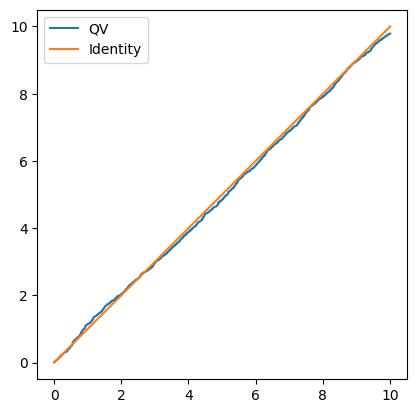

In [13]:
import numpy as np
from pandas import DataFrame

T = 10
n = 2500
dt = T/n

ax = DataFrame({'QV': (np.random.normal(0, np.sqrt(dt), n)**2).cumsum(), 
                'Identity': np.arange(dt, T+dt, dt)
               }, 
               index=np.arange(dt, T+dt, dt)).plot()
ax.set_aspect(1)


## SV Models

All models below are in the risk-neutral world and there can be a price-volatility correlation, meaning $dZ_tdW_t = \rho dt$.

![](../fig/sv.png)


From wikipedia: 
[SV Models](https://en.wikipedia.org/wiki/Stochastic_volatility), 
[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model), 
[LV](https://en.wikipedia.org/wiki/Local_volatility), 
[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)


[GARCH(1, 1) limiting case derivation](https://math.berkeley.edu/~btw/thesis4.pdf)


MD 表 + 連結 + 數學符號 publish 之後會爛掉。這裡放的是圖。原本的 code 在下面被 comment out。圖其實可以不用存起來，直接 snipping tool 剪下之後在 cell 裡貼上就可以了

<!--
|Model| Dynamics | Speed Log Return QV Increase | Note
|--|--|--|--|
|[CEV](https://en.wikipedia.org/wiki/Constant_elasticity_of_variance_model)|$$dS_t = rS_t dt + \sigma S_t^{\beta} dW_t$$ | $$\sigma^2S_t^{2(\beta -1)}$$ | $$\beta< 1: \text{leverage effect; }\beta> 1: \text{inverse leverage effect}$$ |
|[LV](https://en.wikipedia.org/wiki/Local_volatility)| $$dS_t = rS_t dt + \sigma(t, S_t) S_t dW_t$$ | $$\sigma^2(t, S_t)$$ ||
|Heston|$$
\begin{cases}
dS_t = rS_tdt + \sqrt{V_t}S_t dW_t\\
dV_t = \theta(\kappa - V_t)dt + \sigma\sqrt{V_t} dZ_t
\end{cases}
$$| $$V_t$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t$$ |
|[SABR](https://en.wikipedia.org/wiki/SABR_volatility_model)|$$
\begin{cases}
dF_t = \sigma_tF_t^{\beta} dW_t\\
d\sigma_t = \alpha\sigma_t dZ_t
\end{cases}
$$| $$\sigma_t^2F_t^{2(\beta -1)}$$ | $$\sigma_t \text{ accumulates QV at the speed } \alpha^2 \sigma_t^2$$ |
| GARCH(1, 1)|$$
dV_t = \theta(\kappa-V_t)dt + \sigma V_t dW_t
$$| $$?$$ | $$V_t \text{ accumulates QV at the speed } \sigma^2 V_t^2$$ Derivation of limiting case see [here](https://math.berkeley.edu/~btw/thesis4.pdf)|
-->

## Empirically...

* The log return of S&P 500 doesn't accumulate QV at a constant rate $\sigma^2$ per unit time as it's assumed in the Black-Scholes model
* The Heston model assumes that the log return accumulates QV at the rate of the volatility $V_t$, and the volatility accumulates QV at the rate of $\sigma^2 V_t$. So the speed the log return accumulates QV is a constant times the speed the volatility accumulates QV. 

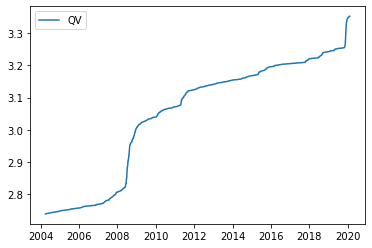

In [3]:
from pandas import DataFrame
import pandas as pd
import numpy as np

# data from 1928/1/1 - 2020/6/1

df = pd.read_csv('../data/^GSPC.csv').set_index('Date')
df = np.log(df[['Adj Close']].pct_change()[1:] + 1)

log_return = df.values

n = len(log_return)
dt = 1/252
ax = DataFrame({'QV': (log_return**2).cumsum()}, index=np.arange(dt+1928, (n+1)*dt+1928, dt)).tail(4000).plot()
# ax.set_aspect(1)



## [Penalty Method for American Put Pricing](https://cs.uwaterloo.ca/~paforsyt/con7.pdf)

\begin{align*}
V_{\tau} = \frac{\sigma^2S^2}{2}V_{SS} + rSV_S - rV + \rho\max(V^{*}-V, 0), 
\end{align*}
where $V^* = (K-S)^+$ is the payoff function, and $\rho$ is a large number. 

* Above the early exercise boundary, the penalty term disappears and the PDE reduces to the Black-Scholes PDE
* Below the boundary, the penalty term dominates and PDE is approximately $V_{\tau} = \rho(V^{*}-V)$ whose solution is $V = V^{*}$


## Formulas I Always Forget

### SABR Model
\begin{align*}
\begin{cases}
dF_t = \alpha_tF_t^{\beta}\,dW_t\\
d\alpha_t = \nu \alpha_t\,dZ_t, \qquad \alpha_0 = \alpha\\
dW_tdZ_t = \rho dt
\end{cases}
\end{align*}
這裡 $\nu$ 是真的 vol of vol，不像 Heston 裡的 $\sigma$ 其實是 volatility of variance。

### ZCB to Forward Rate
\begin{align*}
f(t, T) = -\frac{\partial}{\partial T}\log P(t, T)
\end{align*}

### Ito Quotient Rule
\begin{align*}
\frac{d(X/Y)}{X/Y} = \frac{dX}{X} - \frac{dY}{Y} - \frac{dX}{X}\frac{dY}{Y} + \left(\frac{dY}{Y}\right)^2
\end{align*}

### Fibonacci Sequence
\begin{align*}
F_n = \frac{1}{\sqrt{5}}\left(\left(\frac{1+\sqrt{5}}{2}\right)^n - \left(\frac{1-\sqrt{5}}{2}\right)^n\right)
\end{align*}
CF 是 $x^2 - x - 1$ 所以 $b=-1$，兩根的分子的第一項一定是 1 而不是 -1。兩項中間的負號只要看 $F_0 = 0$ 就不會忘記了。

